# Plotting feature-relative time-lagged 2D maps

Load necessary packages.

In [1]:
import os.path
import xarray as xr
import numpy as np
from waveFilter import kf_filter
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from functions_mpas_aqua import filter_data_for_ccews, filter_data_for_ccews_YHSmethod

from ipywidgets import IntProgress
from IPython.display import display
%matplotlib inline

# for smoothing out fields
import scipy as sp
import scipy.ndimage

# trick to read function in a separate file
import sys
sys.path.append('/glade/u/home/rberrios/python/PRECIP/')
from defineColormaps import *

Define global parameters.

In [2]:
#path to output
pth='/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N/'
exps=['TC_3km']

# build a rectangle in axes coords
left, width = .0125, .5
bottom, height = .465, .5
right = left + width
top = bottom + height

Define wave parameters.

In [3]:
# Set Pre-Defined Arguments for wave filtering
mis = -999
obsPerDay = 4
dt = 6.0
algoName='mpas'
#---- choosing 5S-10N to be consistent w/ ERA5/IMERG
minLat=-5
maxLat=10
#---------------------------------------------------

obsVar = 'pr'
filtVar = obsVar
unit = 'mm hr-1'

waves = {
    'Kelvin': [np.array([1,14],dtype='f'),np.array([2.5,20],dtype='f'),np.array([8,90],dtype='f'),[-1.0,31.0],minLat,maxLat],
    'AD': [np.array([-28,-4],dtype='f'),np.array([5.0,20],dtype='f'),np.array([mis,mis],dtype='f'),[-30.0,1.0],minLat,maxLat],
    'IG1': [np.array([-15,-1],dtype='f'),np.array([1.4,2.6],dtype='f'),np.array([8,90],dtype='f'),[-75.0,-0.0],minLat,maxLat],
    'MRG': [np.array([-10,-1],dtype='f'),np.array([3,10],dtype='f'),np.array([8,90],dtype='f'),[-30.0,1.0],minLat,maxLat],
    'IG0': [np.array([1,14],dtype='f'),np.array([1.8,4.5],dtype='f'),np.array([8,90],dtype='f'),[-30.0,1.0],minLat,maxLat],
    'IG2': [np.array([-15,-1],dtype='f'),np.array([1.25,2.0],dtype='f'),np.array([8,90],dtype='f'),[-30.0,1.0],minLat,maxLat],
    'ER': [np.array([-10,-1],dtype='f'),np.array([10.0,40.0],dtype='f'),np.array([8,90],dtype='f'),[-30.0,1.0],minLat,maxLat],
    # 'TD': [np.array([-20,-6],dtype='f'),np.array([2.5,5.0],dtype='f'),np.array([8,90],dtype='f'),[-30.0,1.0],minLat,maxLat]
    #2/9/2022: modified the space-time filter of TDs to be consistent with Kiladis et al. (2006): wavenumbers 6-greater, and frequencies of 2.5-12 days
    'TD':  [np.array([-20,-6],dtype='f'),np.array([2.5,12.0],dtype='f'),np.array([mis,mis],dtype='f'),[-30.0,1.0],0,10]

}

#increase font size
plt.rcParams.update({'font.size': 14})

Define color maps and level options.

In [4]:
my_dict = {
    'pr': [1.0,'YlGnBu', np.linspace(0,2.0,21), r'rainfall rate anomaly (mm hr$^{-1}$)',colors.LogNorm(vmin=0.1, vmax=10.0),'(a) rainfall rate'],
    'filteredpr': [1.0,'Spectral', np.linspace(-2.5,2.5,21), r'filtered rainfall rate anomaly ($\sigma$)',colors.LogNorm(vmin=0.1, vmax=10.0)],
    'u850': [1,'RdBu_r',np.linspace(-5,5,21),r'850-hPa zonal wind anomaly ($\sigma$)','(a) 850-hPa $u$'],
    'v850': [1,'RdBu_r',np.linspace(-3,3,21),r'850-hPa meridional wind anomaly ($\sigma$)','(a) 200-hPa $v$'],
    'u200': [1,'RdBu_r',np.linspace(-10,10,21),r'200-hPa zonal wind anomaly ($\sigma$)','(b) 200-hPa $u$'],
    'v200': [1,'RdBu_r',np.linspace(-10,10,21),r'200-hPa meridional wind anomaly ($\sigma$)','(b) 200-hPa $v$'],
    'precipw': [1,'BrBG',np.linspace(-5.0,5.0,21),r'precipitable water anomaly ($\sigma$)','(a) precipitable water'],
    'mse_vint': [1.0e-6,'coolwarm',np.linspace(-12.0,12.0,25),'column-integrated moist static energy (10$^{6}$ J m$^{-2}$)'],
    'ushr': [1,'PuOr',np.linspace(-2.5,2.5,21),'200-850 hPa zonal shear (m s$^{-1}$)'],
    'vshr': [1,'PuOr',np.linspace(-2.5,2.5,21),'200-850 hPa meridional shear (m s$^{-1}$)'],
    'shrmag': [1,'RdBu_r',np.linspace(-15,15,21),r'200-850 hPa shear magnitude (m s$^{-1}$)','(b) shear'],
    'SHRM': [1,'RdBu_r',np.linspace(-5,5,21),r'200-850 hPa shear magnitude (m s$^{-1}$)','(b) shear'],
    'VOR850': [1.0e5,defineColormap('vorticity'),np.array([-3,-2,-1.5,-1.0,-0.5,0,0.5,1,1.5,2,3,4,5,6,7,8,9,10,11,12,13,14])*0.5,r'850-hPa relative vorticity anomaly (10$^{-5}$ s$^{-1}$)','(c) vorticity'],
    'SHEAR_VOR': [1.0e5,defineColormap('vorticity'),np.array([-3,-2,-1.5,-1.0,-0.5,0,0.5,1,1.5,2,3,4,5,6,7,8,9,10,11,12,13,14])*0.1,r'850-hPa shear vorticity anomaly (10$^{-5}$ s$^{-1}$)','(c) vorticity'],
    'CURVATURE_VOR': [1.0e5,defineColormap('vorticity'),np.array([-3,-2,-1.5,-1.0,-0.5,0,0.5,1,1.5,2,3,4,5,6,7,8,9,10,11,12,13,14])*0.1,r'850-hPa shear vorticity anomaly (10$^{-5}$ s$^{-1}$)','(c) vorticity'],
    'STRETCHING850': [1.0e5*3600,'RdGy_r',np.linspace(-0.2,0.2,21),r'850-hPa vortex stretching anomaly (10$^{-5}$ s$^{-1}$ h$^{-1}$)','(c) vorticity'],
    'circ_vint': [1.0e5,'RdGy',np.linspace(-3.5,3.5,21),'vertically-integrated circulation anomaly (10$^{-5}$ s$^{-1}$)'],
    'qv500':[1000.0,'BrBG',np.linspace(-0.6,0.6,21),'500-hPa water vapor mixing ratio (g kg$^{-1}$)'],
    'SAT_FRACTION':[1.0,'BrBG',np.linspace(-0.1,0.1,21),'saturation fraction anomaly'],
    'RHUM':[1.0,'BrBG',np.linspace(-10.0,10.0,21),r'600-hPa relative humidity anomaly ($\sigma$)','(b) 600-hPa RH' ],
    'hfx': [1.0,'RdBu_r',np.linspace(-10,10,21),'surface sensible heat flux (W m$^{-2}$)'],
    'qfx': [2.5e6,'RdBu_r',np.linspace(-20,20,21),'surface latent heat flux (W m$^{-2}$)'],
    'CI': [1.0,'RdBu_r',np.linspace(-1.25,1.25,21),'coupling index (K)'],
    'olrtoa': [1.0,'RdBu_r',np.linspace(-60,60,21),'outgoing longwave radiation anomaly (W m$^{-2}$)'],
    'SF' : [1.0,'RdBu_r',np.linspace(-10,10,21),'surface heat fluxes anomaly (W m$^{-2}$)'],
    'R' : [1.0,'RdBu_r',np.linspace(-10,10,21),'radiative fluxes anomaly (W m$^{-2}$)'],
    'VI' : [1.0,'RdBu_r',np.linspace(-0.1,0.1,21),r'ventilation index anomaly','(a) ventilation'],
    'MPI_VMAX' : [1.0,'RdBu_r',np.linspace(-3.0,3.0,21),r'MPI anomaly','(d) PI'],
    'CHI_TE' : [1.0,'RdBu_r',np.linspace(-0.4,0.4,21),'entropy deficit anomaly','(c) entropy deficit'],
    'GPI_E' : [1.0e14,'PRGn',np.linspace(-0.4,0.4,21),'GPI anomaly','(c) GPI'],
    'DIV200': [1.0e5,'PRGn',np.linspace(-1.5,1.5,21),r'200-hPa divergence anomaly ($\sigma$)','(d) divergence'],
    'divlo': [1.0e5,'RdGy',np.linspace(-1.5,1.5,21),'850$-$1000-hPa divergence anomaly (10$^{-5}$ s$^{-1}$)'],
    'u200Yang': [1.0,'RdBu_r',np.linspace(-10,10,21),'200-hPa filtered zonal wind (m s$^{-1}$)',''],
    'u850Yang': [1.0,'RdBu_r',np.linspace(-10,10,21),'850-hPa filtered zonal wind (m s$^{-1}$)',''],
    'mslp': [0.01,'viridis',np.linspace(970,1020,21),'MSLP anomaly (hPa)'],

}

Define function that finds the wave peaks graphically.

In [5]:
def find_wave_peak_graphically(fname,waveName):
    ds = xr.open_dataset(fname)

    #get latitude ranges for each wave
    minLat = waves[waveName][4]
    maxLat = waves[waveName][5]

    obsData = ds.pr.sel(lat=slice(minLat,maxLat)).mean(dim='lat')

#     #subtract time mean
#     print('calculating and subtracting climo...')
#     obsData = obsData-obsData.mean(dim='time')
#     print('done w/ climo')
    
    lon = obsData.lon
    obsTime = obsData.time
    nObs=len(obsTime)

    # Extend filtering to 700 days
    filtTime = np.arange(0,len(obsTime)+702)

    # Incorporate original data into array
    filtData=np.zeros([len(filtTime),len(lon)],dtype='f')
    filtData[0:obsData.shape[0],:]=obsData

    #### # Filter (KELVIN)
    #################################################
    print("\n##############################\nFiltering %s\n"%waveName)

    wave = filtData
    wave_longname="Kelvin Waves in "+filtVar.upper()
    wave_filter="Straub & Kiladis (2002) to 20 days"
    wave_wavenumber=waves[waveName][0]
    wave_period=waves[waveName][1]
    wave_depth=waves[waveName][2]
    wave_units=unit

    wave[:,:]=kf_filter(filtData[:,:],obsPerDay,\
                   wave_period[0],wave_period[1],\
                   wave_wavenumber[0],wave_wavenumber[1],\
                   wave_depth[0],wave_depth[1],waveName)
    waveData = xr.DataArray(wave[0:len(obsTime),:].squeeze(),coords=[obsTime,lon],dims=['time','lon'])

    #differentiate twice
    waveDatadt = waveData.differentiate('time')
    waveDatadt2 = waveDatadt.differentiate('time')
    
    #retain only strong waves and where d/dt(d/dt(wave)) < 0 [a maximum] 
    #further restrict only to Pacific ocean
    print('considering 1sigma waves!')
    waveCrests = waveDatadt.where( (waveData/waveData.std(dim=('time'))>1.0) & (xr.ufuncs.fabs(waveDatadt) <= 1.0e-14) & 
                                      (waveDatadt2 < 0) & (waveData.lon >= 0.0) & 
                                      (waveData.lon <= 360.0))

    time_in_days = np.arange(0,len(waveData.time)*dt,dt)/24
    [X,Y] = np.meshgrid(waveData.lon,time_in_days)
    plt.contourf(X,Y,waveData)
    plt.colorbar()

    cs = plt.contour(X,Y,waveCrests,colors='k',levels=[0])
    
    plt.close()
    
    lon_waves = []
    time_waves = []
    for segs in cs.allsegs[0][:]:
        for i in np.arange(0,len(segs[:,0])):
            lon_waves.append(segs[i,0])
            time_waves.append(obsTime.sel(time=obsTime[0].squeeze()+pd.to_timedelta(segs[i,1],unit='d'),method='nearest') )
    
    del(filtData)
    del(obsData)
            
    return lon_waves, time_waves, waveData, waveDatadt

Define function that reads and saves wave-relative fields.

In [10]:
def read_feature_relative_data(expName,waveName,list_of_vars,list_of_levels,laggedTimes,anom,**kwargs):
        
    if ('allTCG' in waveName):
        # find the TCG locations
        tcgen_info = pd.read_csv('TCG_TC_3km.csv')
        tcgen_info = tcgen_info[tcgen_info.lat <= 20]
        lon = tcgen_info.lon.values
        time = []
        for index, row in tcgen_info.iterrows():
            ctim = pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S')
            time.append(ctim)  
        # number of points to skip
        skip=1
    elif (waveName=='KelvinTCG'):
        tcgen_info = pd.read_csv('Kelvin_TCG_on_peak_TempestExtremes.csv')#,parse_dates=['time'])
        tcgen_info = tcgen_info[tcgen_info.lat <= 20]
        #restrict for a case study
        # print('single case study')
        # tcgen_info = tcgen_info[tcgen_info.ID == 1186] #1186[trio], 2996, 1445, 6199
        lon = tcgen_info.lon.values
        time = []
        for index, row in tcgen_info.iterrows():
            ctim = pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S')
            time.append(ctim)  
        # number of points to skip
        skip=1
    elif (waveName=='notKelvinTCG'):
        tcgen_info = pd.read_csv('Kelvin_TCG_not_on_peak_TempestExtremes.csv')#,parse_dates=['time'])
        tcgen_info = tcgen_info[tcgen_info.lat <= 20]
        #restrict for a case study
        # print('single case study')
        # tcgen_info = tcgen_info[tcgen_info.ID == 1186] #1186[trio], 2996, 1445, 6199
        lon = tcgen_info.lon.values
        time = []
        for index, row in tcgen_info.iterrows():
            ctim = pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S')
            time.append(ctim)  
        # number of points to skip
        skip=1
    elif ('TDTCG' in waveName):
        tcgen_info = pd.read_csv('TD_TCG_on_peak.csv')#,parse_dates=['time'])
        tcgen_info = tcgen_info[tcgen_info.lat <= 20]
        lon = tcgen_info.lon.values
        time = []
        for index, row in tcgen_info.iterrows():
            ctim = pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S')
            time.append(ctim)
        # number of points to skip
        skip=1
    elif ('caseStudy' in waveName):
        # find the TCG locations
        tcgen_info = pd.read_csv('TCG_TC_3km_35N1tstepwarmcore_unstructuredmesh.csv')
        tcgen_info = tcgen_info[tcgen_info.ID==kwargs['track_id']]
        lon = tcgen_info.lon.values
        time = []
        for index, row in tcgen_info.iterrows():
            ctim = pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S')
            time.append(ctim)  
        # number of points to skip
        skip=1
    else:
        #check if I have already saved the filtered wave data
        waveFile = pth+expName+'/latlon/'+waveName+'_r3600x1800.csv'
        if os.path.exists(waveFile):
            df = pd.read_csv(waveFile)
            lon=df.lon.values
            time=[]
            for index, row in df.iterrows():
                ctim = pd.to_datetime(row['time'],format='%Y-%m-%d %H:%M:%S')
                time.append(ctim) 
        else:
            fname = pth+expName+'/latlon/diags_gaussian_global_nospinup_r3600x1800.nc'
            lon, time, _, _ = find_wave_peak_graphically(fname,waveName)
            #save file for future use
            data2save = {
                'lon':  lon,
                'time': [t.values for t in time]
            }
            df=pd.DataFrame(data2save)
            df.to_csv(waveFile,index=False)
            
        # # find wave locations
        # fname = pth+expName+'/latlon/diags_gaussian_global_nospinup_r3600x1800.nc'
        # lon, time, _, _ = find_wave_peak_graphically(fname,waveName)
        # number of points to skip
        skip=10
    
    output = {}
    for i in np.arange(0,len(list_of_vars)):
        varName = list_of_vars[i]
        print(varName)
        level = list_of_levels[i]

        if ('filtered' not in varName):
            fname = pth+expName+'/latlon/diags_gaussian_global_nospinup_r3600x1800.nc'
            ds = xr.open_dataset(fname).sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))

            if (level == 0.0):
                if (varName == 'qv_vint_lo'):
                    del(ds)
                    ds = xr.open_dataset(pth+expName+'/latlon/diags3d_gaussian_global_nospinup_n400.nc').sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))
                    ds[varName] = ds.qv_isobaric.sel(plev=slice(60000,100000)).sum('plev')*2500.0/9.81
                elif (varName == 'SF'):
                    ds[varName] = (ds.qfx*2.5e6 + ds.hfx)
                elif (varName == 'eth_diff'):
                    ds[varName] = ds.eth_bl-ds.eth_lt
                elif (varName == 'mse_bl'):
                    ds3d = xr.open_dataset(pth+expName+'/latlon/diags3d_gaussian_global_nospinup_n400.nc').sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']),level=slice(0,500))
                    print(ds3d.level)
                    ds[varName] = (ds3d.temperature*1004.1 + ds3d.qv*2.5e6 + ds3d.level*9.81).mean('level')
                    del(ds3d)
                elif (varName == 'mse_lt'):
                    ds3d = xr.open_dataset(pth+expName+'/latlon/diags3d_gaussian_global_nospinup_n400.nc').sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']),level=slice(1000,2000))
                    print(ds3d.level)
                    ds[varName] = (ds3d.temperature*1004.1 + ds3d.qv*2.5e6 + ds3d.level*9.81).mean('level')
                    del(ds3d)
                elif (varName == 'SHEAR_VOR'):
                    Rearth = 6379.0e3
                    uwind = ds.u850
                    vwind = ds.v850
                    U = (uwind**2.0 + vwind**2.0)**0.5
                    x = np.radians(U.lon)*Rearth
                    y = np.radians(U.lat)*Rearth
                    dudx = np.gradient(uwind,x,axis=2)
                    dudy = np.gradient(uwind,y,axis=1)
                    dvdx = np.gradient(vwind,x,axis=2)
                    dvdy = np.gradient(vwind,y,axis=1)
                    ds[varName] = (U**(-2.0))*( (vwind*uwind*dudx) +\
                                                (vwind*vwind*dvdx) -\
                                                (uwind*uwind*dudy) -\
                                                (uwind*vwind*dvdy))
                elif (varName == 'CURVATURE_VOR'):
                    Rearth = 6379.0e3
                    uwind = ds.u850
                    vwind = ds.v850
                    U = (uwind**2.0 + vwind**2.0)**0.5
                    x = np.radians(U.lon)*Rearth
                    y = np.radians(U.lat)*Rearth
                    dudx = np.gradient(uwind,x,axis=2)
                    dudy = np.gradient(uwind,y,axis=1)
                    dvdx = np.gradient(vwind,x,axis=2)
                    dvdy = np.gradient(vwind,y,axis=1)
                    ds[varName] = (U**(-2.0))*( (uwind*uwind*dudx) -\
                                                (vwind*vwind*dudy) -\
                                                (uwind*uwind*dudx) +\
                                                (uwind*vwind*dvdy))
                elif (varName == 'VI') | ('VOR' in varName) |\
                     (varName == 'CHI_TE') | (varName == 'SHRM') | \
                     (varName == 'RHUM') | ('DIV' in varName) | \
                     (varName == 'MPI_VMAX') :
                    del(ds)
                    ds = xr.open_dataset(pth+expName+'/latlon/genesis_indexes_r3600x1800_revised_04042023.nc').sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))
                elif (varName == 'GPI_E'):
                    del(ds)
                    ds = xr.open_dataset(pth+expName+'/latlon/genesis_indexes_r360x180.nc').sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))
                    #calculate the GPI from Emanuel (2010), except using CHI from the ventilation index
                    MPI = ds.MPI_VMAX
                    CHI = ds.CHI_TE
                    VOR = ds.VOR850
                   # # smooth out vorticity
                   #  sigma=5.0
                   #  VOR = xr.DataArray(sp.ndimage.filters.gaussian_filter(VOR, sigma, mode='constant'),coords=VOR.coords,dims=VOR.dims)
                    # we need absolute vorticity
                    fcor = 2.0*7.292e-5*np.sin(np.radians(VOR.lat))
                    VOR = VOR+fcor
                    SHR = ds.SHRM
                    # restrict to positive vorticity and non-zero CHI_TE
                    VOR = VOR.where(VOR>0.0)
                    CHI = CHI.where(CHI>0.0)
                    # restrict to MPI - 35 > 0
                    MPI = MPI-35.0
                    MPI = MPI.where(MPI>0.0,0.0)
                    # add 25 m/s to shear
                    SHR = SHR+25.0
                    ds[varName] = ((np.fabs(VOR)**3.0) * (CHI**(-4.0/3.0)) * (MPI**3.0))/(SHR**4.0)
                elif (varName == 'mse_vint_hadvx_eddy'):
                    del(ds)
                    fname3d=pth+expName+'/latlon/diags3d_gaussian_global_nospinup_r360x180.nc'
                    ds = xr.open_dataset(fname3d).sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))
                    z = ds.level
                    dz=np.gradient(z)
                    rhod=ds.rhod
                    mse=ds.mse
                    u = ds.uReconstructZonal
                    #calculate the time mean
                    tMean = u.mean(dim=('time'))
                    #subtract the time AND zonal means of the original data
                    u = u-tMean.mean(dim=('lon'))
                    mse_x = xr.DataArray(np.gradient(mse,np.radians(mse.lon)*6378.1e3,axis=2),coords=mse.coords,dims=mse.dims)
                    ds[varName] = -1.*(u*mse_x*dz*rhod).sum('level')
                    del(u,mse,mse_x)
                elif (varName == 'mse_mean_vint_hadvy_eddy'):
                    del(ds)
                    fname3d=pth+expName+'/latlon/diags3d_gaussian_global_nospinup_r360x180.nc'
                    ds = xr.open_dataset(fname3d).sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))
                    z = ds.level
                    dz=np.gradient(z)
                    rhod=ds.rhod
                    mse=ds.mse.mean('time').mean('lon')
                    v = ds.uReconstructMeridional
                    #calculate the time mean
                    tMean = v.mean(dim=('time'))
                    #subtract the time AND zonal means of the original data
                    v = v-tMean.mean(dim=('lon'))
                    mse_y = xr.DataArray(np.gradient(mse,np.radians(mse.lat)*6378.1e3,axis=0),coords=mse.coords,dims=mse.dims)
                    ds[varName] = -1.*(v*mse_y*dz*rhod).sum('level')
                    del(v,mse,mse_y) 
                elif (varName == 'mse_eddy_vint_hadvy_eddy'):
                    del(ds)
                    fname3d=pth+expName+'/latlon/diags3d_gaussian_global_nospinup_r360x180.nc'
                    ds = xr.open_dataset(fname3d).sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))
                    z = ds.level
                    dz=ds.dz
                    rhod=ds.rhod
                    mse=ds.mse
                    #calculate the time mean
                    tMean = mse.mean(dim=('time'))
                    #subtract the time AND zonal means of the original data
                    mse = mse-tMean.mean(dim=('lon'))
                    v = ds.uReconstructMeridional
                    #calculate the time mean
                    tMean = v.mean(dim=('time'))
                    #subtract the time AND zonal means of the original data
                    v = v-tMean.mean(dim=('lon'))
                    mse_y = xr.DataArray(np.gradient(mse,np.radians(mse.lat)*6378.1e3,axis=1),coords=mse.coords,dims=mse.dims)
                    ds[varName] = -1.*(v*mse_y*dz*rhod).sum('level')
                    del(v,mse,mse_y)
                elif (varName == 'mse_vint_vadv'):
                    del(ds)
                    fname3d=pth+expName+'/latlon/diags3d_gaussian_global_nospinup_r360x180.nc'
                    ds = xr.open_dataset(fname3d).sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))
                    z = ds.level.squeeze()
                    dz = ds.dz.squeeze()
                    rhod=ds.rhod
                    wwind = ds.w
                    mse=ds.mse
                    mse_z = xr.DataArray(np.gradient(mse,z,axis=3),coords=mse.coords,dims=mse.dims)
                    dumvar=-1.0*(wwind*mse_z*dz*rhod)
                    ds[varName] = dumvar.sum('level')
                elif (varName == 'mse_vint_growth'):
                    mse = ds.mse_vint
                    mse = mse-mse.mean('lon').mean('time')
                    time_array = (ds.time.values-ds.time[0].values)/np.timedelta64(1, 's')
                    dmdt = xr.DataArray(np.gradient(mse,time_array,axis=0),dims=mse.dims,coords=mse.coords)
                    ds[varName] = (mse*dmdt)/(mse*mse)
                elif (varName == 'mse_vint_dt'):
                    mse = ds.mse_vint
                    mse = mse-mse.mean('lon').mean('time')
                    time_array = (ds.time.values-ds.time[0].values)/np.timedelta64(1, 's')
                    ds[varName] = xr.DataArray(np.gradient(mse,time_array,axis=0),dims=mse.dims,coords=mse.coords)
                elif ('STRETCHING' in varName):
                    del(ds)
                    ds = xr.open_dataset(pth+expName+'/latlon/genesis_indexes_r3600x1800_revised_04042023.nc').sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))
                    fCor = 2.0*7.292e-5*np.sin(np.radians(ds.lat))
                    absVOR850 = ds.VOR850+fCor
                    ds[varName] = -1.0*(absVOR850*ds.DIV850)
                newvarName = varName
            else:
                if ('Yang' in varName):
                    if (varName in ds.variables):
                        newvarName=varName
                        print('variable already calculated')
                    else:
                        del(ds)
                        fname=pth+expName+'/latlon/diags_gaussian_global_nospinup_r360x180.nc'
                        ds = xr.open_dataset(fname).sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))

                        # check if we already have the variable in the dataset
                        # we want filtered winds using the YHS method
                        plev = str(int(level))
                        uname = 'u'+plev
                        vname = 'v'+plev
                        # assuming it's the same wave
                        print('filtering')
                        uWave, vWave, zWave = filter_data_for_ccews_YHSmethod(fname,uname,vname,'z',obsPerDay,'ER1')
                        ds[uname+'Yang'] = uWave
                        ds[vname+'Yang'] = vWave
                        print(ds)
                    newvarName=varName
                else:
                    del(ds)
                    fname = pth+expName+'/latlon/diags3d_gaussian_global_nospinup_r3600x1800.nc'
                    ds = xr.open_dataset(fname).sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))                    
                    newvarName = '%s%s'%(varName,'%3.2fkm'%(level/1000))
                    print(newvarName)
                    ds[newvarName] = ds[varName].sel(level=level,method='nearest')
            print('not subtracting the time and zonal mean')
            # #remove the time mean AND zonal mean
            # if ('hadv' not in varName) & ('vadv' not in varName) & ('mslp' not in varName) & (anom==True):
            #     print('subtracting time and zonal mean')
            #     ds[newvarName] = ds[newvarName]-ds[newvarName].mean(dim=('time')).mean('lon')
                
        elif (varName == 'filteredpr'):
            newvarName = varName
            #check if I have already saved the filtered wave data
            waveFile = pth+expName+'/latlon/'+kwargs['waveName4Plot']+'2D_r360x180.nc'
            if os.path.exists(waveFile):
                ds=xr.open_dataset(waveFile).sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))
            else:
                # we don't have the data saved, so we have to filter out
                fname = pth+expName+'/latlon/diags_gaussian_global_nospinup_r3600x1800.nc'
                ds = xr.open_dataset(fname).sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))
                # check if we want to plot the same wave we're using as a reference
                if ('waveName4Plot' in kwargs):
                    wave2filter = kwargs['waveName4Plot']
                else:
                    wave2filter = waveName
                ds[newvarName] = filter_data_for_ccews(fname,'pr',4,wave2filter,minLat=kwargs['minLatPlot'],maxLat=kwargs['maxLatPlot'],avgLat=False)
                # save file for later use
                ds[newvarName].to_netcdf(waveFile)
        elif (varName == 'filteredprWave2'):
            newvarName = varName
            #check if I have already saved the filtered wave data
            waveFile = pth+expName+'/latlon/'+kwargs['waveName4Plot2']+'2D_r360x180.nc'
            if os.path.exists(waveFile):
                ds=xr.open_dataset(waveFile).sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))
                # ds=ds.rename({'filteredpr':'filteredprWave2'})
                # print(ds)
            else:
                # we don't have the data saved, so we have to filter out           
                fname = pth+expName+'/latlon/diags_gaussian_global_nospinup_r360x180.nc'
                ds = xr.open_dataset(fname).sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))
                if ('waveName4Plot2' in kwargs):
                    wave2filter = kwargs['waveName4Plot2']
                else:
                    wave2filter = waveName
                ds[newvarName] = filter_data_for_ccews(fname,'pr',4,wave2filter,minLat=kwargs['minLatPlot'],maxLat=kwargs['maxLatPlot'],avgLat=False)
                # save file for later use
                ds[newvarName].to_netcdf(waveFile)
                
        #keep only the variable of interest in the dataset
        keep_vars = [newvarName,'lon','lat','time']
        ds = ds.drop([v for v in ds.variables if v not in keep_vars])

        if ('caseStudy' not in waveName):
            waveLons = lon[0:len(lon):skip]
            waveTime = time[0:len(lon):skip]
        else:
            waveLons = lon
            waveTime = time
        print(varName,len(waveLons))

        dx = np.abs(ds.lon[1]-ds.lon[0])
        if (waveName == 'Kelvin'):
            dLon = 45.0
        else:
            dLon = 60.0
        lon_array_target = xr.DataArray(np.arange(-dLon,dLon+dx,dx))
        lat_array_target = ds.lat

        centered_data_0s = np.empty( (len(laggedTimes),len(waveLons),len(lat_array_target),len(lon_array_target)) )
        centered_data_0s[:] = np.nan
        IDs = np.arange(0,len(waveLons))

        ds_out = xr.DataArray(centered_data_0s,dims=('lag','ID','lat','lon'),coords=(laggedTimes,IDs,lat_array_target,lon_array_target))

        for t in np.arange(0,len(laggedTimes)):
            lag = laggedTimes[t]
            #loop through data, obtain datetime object for valid time, and get corresponding index
            for d in np.arange(0,len(waveLons)):
                ctim = waveTime[d]+pd.to_timedelta(lag,unit='D')
                if (ctim < ds.time.min().values) | (ctim > ds.time.max().values):
                    continue
                else:
                    clon = waveLons[d]

                    #we'd like to save nx x ny data points, but in some cases the points may be too close to the boundarys
                    lon1 = clon-dLon
                    lon2 = clon+dLon

                    #read in variable
                    var2tst = ds[newvarName].sel(time=ctim,method='nearest')

                    #get storm-centered fields
                    var2tst['lon'] = var2tst.lon-ds.lon.sel(lon=clon,method='nearest')

                    if (var2tst.lon.max() < lon_array_target.max()):
                        #need to find lon<-180 and add 360
                        lon_temp = var2tst.lon.where(var2tst.lon>-180.0,var2tst.lon+360.0)
                        #reassign longitude coordinate
                        var2tst['lon'] = lon_temp
                        #pivot around longitude 0 by finding longitudes <=0 and those > 0
                        group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                        group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                        #make sure that the coordinate is in ascending order
                        group2 = group2.sortby(group2.lon)
                        del(var2tst)
                        #finally merge the two!
                        var2tst = xr.concat([group1,group2],dim='lon')
                    elif (var2tst.lon.min() > lon_array_target.min() ):
                        lon_temp = var2tst.lon.where(var2tst.lon<180.0,var2tst.lon-360.0)
                        var2tst['lon'] = lon_temp
                        group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                        group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                        group1 = group1.sortby(group1.lon)
                        group2 = group2.sortby(group2.lon)
                        del(var2tst)
                        var2tst = xr.concat([group1,group2],dim='lon')

                    ds_out[t,d,:] = var2tst.sel(lon=slice(-(dLon+dx/2),dLon+dx/2)).values

                    # fig=plt.figure()
                    # plt.contourf(ds_out[d,:])
                    # plt.title(d)
                    # display(fig)
                    # plt.close()
                    # break

        centered_data_avg = ds_out.mean(dim='ID')
        output[newvarName] = centered_data_avg
        if (varName == 'mse_vint_growth'):
            print(centered_data_avg.mean('lat').sum())
            
        del(ds)
        del(centered_data_avg)
    return output

Read and plot 2D maps.

In [14]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import matplotlib.colors
from matplotlib.colors import ListedColormap

def plot_multi_panel_latlon_waverelative(laggedTimes,field1,uwind,vwind,**kwargs):
    # get arguments from the function
    plottingOpts = {
        'cmap' : 'coolwarm',
        'panelLabels' : False,
        'pLabel' : '',
        'cLabel' : ''
    }
    for key in kwargs:
        plottingOpts[key] = kwargs[key]
        
    
    nTimes=len(laggedTimes)

    # Get geographical limits for figure
    minLon = field1.lon.min()
    maxLon = field1.lon.max()
    minLat = field1.lat.min()
    maxLat = field1.lat.max()+0.1
    centerLon = 0.0
    lat_interval = 5.0
    lon_interval = 15.0
    
    # build a rectangle in axes coords
    left, width = .015, .5
    bottom, height = .485, .5
    right = left + width
    top = bottom + height
    
    # Open Figure
    projection = ccrs.PlateCarree(central_longitude=centerLon)

    # Define the figure and each axis for the n rows, where n = number of lagged times
    fig, axs = plt.subplots(nrows=nTimes,
                            subplot_kw={'projection': projection},
                            figsize=(4.5,10),sharex=True,dpi=300) ###remember to change to (4.5,10)!
    
    for i, ax in enumerate(axs.flatten()):
        
        ax.set_extent([minLon, maxLon, minLat, maxLat], ccrs.PlateCarree()) 

        # Add Latitudes
        ax.set_yticks(np.arange(minLat, maxLat, lat_interval), ccrs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

        # Add Longitudes
        ax.set_xticks(np.arange(minLon, maxLon, lon_interval), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        
        # reduce the size of lat/lon labels
        ax.tick_params(which='major', labelsize=8)

        [X,Y] = np.meshgrid(field1.lon,field1.lat)
        # --- smooth out noisy variables, such as vorticity and divergence
        if ('VOR' in varName) | ('DIV' in varName) | ('STRETCHING' in varName):
            sigma=2.0
            field1[i,:] = sp.ndimage.filters.gaussian_filter(field1[i,:], sigma)

        print('%s: %f, %f'%(varName,field1[i,:].min().values,field1[i,:].max().values))
        im=ax.contourf(X,Y,field1[i,:],cmap=my_dict[varName][1],levels=my_dict[varName][2],extend='both')

        [X,Y] = np.meshgrid(uwind.lon,uwind.lat)
        if ( (uwind.lon[2]-uwind.lon[1]) < 0.5):
            vc=ax.quiver(X[::20,::20],Y[::20,::20],uwind[i,::20,::20],vwind[i,::20,::20],color='k')#,scale=60)
        else:
            vc=ax.quiver(X[::1,::1],Y[::1,::1],uwind[i,::1,::1],vwind[i,::1,::1],color='k')#,scale=60)

        if 'field2' in kwargs:
            # do gaussian filtering to smooth out before plotting
            sigma=2.0
            field2=kwargs['field2']
            [X,Y]=np.meshgrid(field2.lon,field2.lat)
            field2[i,:]=sp.ndimage.filters.gaussian_filter(field2[i,:], sigma)
            if (waveName == 'TD'):
                ax.contour(X,Y,field2[i,:],colors='black',levels=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],linewidths=2)
            else:
                ax.contour(X,Y,field2[i,:],colors='black',levels=[0.1,0.2,0.3,0.4,0.5,1.0,1.5],linewidths=1)

        if 'field3' in kwargs:
            # do gaussian filtering to smooth out before plotting
            sigma=2.0
            field3=kwargs['field3']
            [X,Y]=np.meshgrid(field3.lon,field3.lat)
            field3[i,:]=sp.ndimage.filters.gaussian_filter(field3[i,:], sigma)
            if (waveName == 'TD'):   
                ax.contour(X,Y,field3[i,:],colors='black',levels=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],linewidths=2)             
            else:
                cl1=ax.contour(X,Y,field3[i,:],colors='white',levels=[0.25,0.5,1.0,1.5],linewidths=2) #levels=np.arange(0.5,6.5,0.5)
                cl2=ax.contour(X,Y,field3[i,:],colors='magenta',levels=[0.25,0.5,1.0,1.5],linewidths=1) #levels=np.arange(0.5,6.5,0.5)
                ax.clabel(cl1, cl1.levels, inline=1, fontsize=6,fmt='%2.2f')
                ax.clabel(cl2, cl2.levels, inline=1, fontsize=6,fmt='%2.2f')                
        
        if (varName == 'olrtoa') | (varName == 'pr'):
            pLabel = '('+chr(6+97+i)+') t = %2.2f days'%laggedTimes[i]
        else:
            pLabel = '('+chr(97+i)+') t = %2.2f days'%laggedTimes[i]

        # add panel labels if requested
        if ('panelLabels' in kwargs): 
            if (kwargs['panelLabels']):
                ax.text(left, top, pLabel,
                    horizontalalignment='left',
                    verticalalignment='top',
                    transform=ax.transAxes,
                    fontsize='10', bbox=dict(facecolor='white', alpha=0.85,edgecolor='none',pad=0.1)) 

    # add common colorbar
    cbar_ax = fig.add_axes([0.125, 0.065, 0.75, 0.02])
    cb=fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
    cb.ax.tick_params(labelsize=8)
    
    # add label bar
    cb.set_label(plottingOpts['cLabel'],fontsize=8)

    #add quiver legend
    qk = ax.quiverkey(vc, 0.84, 0.885, 5.0, r'$5 \frac{m}{s}$', labelpos='E',
                   coordinates='figure',fontproperties={'size':6})
        
    display(fig)
    # plt.savefig('./Figures/%s+filteredpr_850hPawinds_%s_multiTimes.jpeg'%(varName,waveName),bbox_inches='tight',dpi=600)
    plt.close()
        

def plot_latlon_waverelative(field1,uwind,vwind,**kwargs):

    print(field1.min(),field1.max())
    plottingOpts = {
        'cmap' : 'coolwarm',
        'panelLabels' : False,
        'pLabel' : '',
        'cLabel' : ''
    }
    for key in kwargs:
        plottingOpts[key] = kwargs[key]
    
    minLon = field1.lon.min()
    maxLon = field1.lon.max()
    minLat = -5#field1.lat.min()
    maxLat = field1.lat.max()+0.1
    centerLon = 0.0
    lat_interval = 5.0
    lon_interval = 15.0
    
    # Open Figure
    projection = ccrs.PlateCarree(central_longitude=centerLon)
    fig, ax = plt.subplots(dpi=300, facecolor='w', edgecolor='k')
    fig.tight_layout()

    ax=plt.subplot(projection=projection)
    ax.set_extent([minLon, maxLon, minLat, maxLat], ccrs.PlateCarree()) 

    # Add Latitudes
    ax.set_yticks(np.arange(minLat, maxLat, lat_interval), ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

    # Add Longitudes
    ax.set_xticks(np.arange(minLon, maxLon, lon_interval), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)

    [X,Y] = np.meshgrid(field1.lon,field1.lat)
    if (varName=='pr'):
        # logarithmic scale and colormap
        cmap = my_dict[varName][1]
        a1 = 10.**(np.arange(-2, 1)) 
        a2 = np.arange(1,10,1)
        levels = np.outer(a1, a2).flatten()
        levels = levels[levels>=0.05]
        levels = levels[levels<=5.0]
        print(levels)
        # norm = matplotlib.colors.BoundaryNorm(boundaries=levels, ncolors=len(levels)-1)
        norm = colors.LogNorm(vmin=levels.min(), vmax=levels.max())
        im=ax.contourf(X,Y,field1,cmap=cmap,levels=levels,norm=norm,extend='both')
        cb=plt.colorbar(im,shrink=0.75,pad=0.1,orientation='horizontal',ticks=levels[::2])
        cb.ax.set_xticklabels(['0.05','0.07','0.09','0.2','0.4','0.6','0.8','1.0','3.0','5.0'],fontsize=10)
    else:
        # --- smooth out noisy variables, such as vorticity and divergence
        if ('VOR' in varName) | ('DIV' in varName):
            sigma=2.0
            field1 = sp.ndimage.filters.gaussian_filter(field1, sigma)
            
    im=ax.contourf(X,Y,field1,cmap=my_dict[varName][1],levels=my_dict[varName][2],extend='both')
    cb=plt.colorbar(im,shrink=0.75,orientation='horizontal')
    cb.set_label(plottingOpts['cLabel'])

    [X,Y] = np.meshgrid(uwind.lon,uwind.lat)
    vc=ax.quiver(X[::20,::20],Y[::20,::20],uwind[::20,::20],vwind[::20,::20],color='k')#,scale=60)
    # vc=ax.quiver(X[::1,::1],Y[::1,::1],uwind[::1,::1],vwind[::1,::1],color='k')#,scale=60)
    
    if 'field2' in kwargs:
        print(kwargs['field2'].min(),kwargs['field2'].max())
        # do gaussian filtering to smooth out before plotting
        sigma=2.0
        field2=kwargs['field2']
        [X,Y]=np.meshgrid(field2.lon,field2.lat)
        field2=sp.ndimage.filters.gaussian_filter(field2, sigma)
        if (waveName == 'TD'):
            ax.contour(X,Y,field2,colors='black',levels=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],linewidths=2)
        else:
            ax.contour(X,Y,field2,colors='black')#,levels=[0.1,0.2,0.3,0.4,0.5,1.0,1.5],linewidths=2)

    if 'field3' in kwargs:
        print(kwargs['field3'].min(),kwargs['field3'].max())
        # do gaussian filtering to smooth out before plotting
        sigma=2.0
        field3=kwargs['field3']
        [X,Y]=np.meshgrid(field3.lon,field3.lat)
        field3=sp.ndimage.filters.gaussian_filter(field3, sigma)
        if (waveName == 'TD'):   
            ax.contour(X,Y,field3,colors='black',levels=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],linewidths=2)             
        else:
            ax.contour(X,Y,field3,colors='white',levels=[0.25,0.5,1.0,1.5],linewidths=3) #levels=np.arange(0.5,6.5,0.5)
            ax.contour(X,Y,field3,colors='magenta',levels=[0.25,0.5,1.0,1.5],linewidths=2) #levels=np.arange(0.5,6.5,0.5)
    
    #add quiver legend
    qk = ax.quiverkey(vc, 0.85, 0.96, 5, r'$5 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
    
    # add panel labels if requested
    if ('panelLabels' in kwargs): 
        if (kwargs['panelLabels']):
            pLabel=kwargs['pLabel']
            ax.text(left, top, pLabel,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,
                fontsize='10', bbox=dict(facecolor='white', alpha=0.85)) 
    
    display(fig)
    # plt.savefig('./Figures/%s+filteredpr_850hPawinds_%s_t%4.4i.jpeg'%(varName,waveName,int(laggedTime*24.0)),bbox_inches='tight',dpi=600)
    plt.close()

VOR850
not subtracting the time and zonal mean
VOR850 1
u850
not subtracting the time and zonal mean
u850 1
v850
not subtracting the time and zonal mean
v850 1
filteredpr
filteredpr 1
filteredprWave2
filteredprWave2 1
lag: -5.00
<xarray.DataArray ()>
array(-86.381345)
Coordinates:
    lag      float64 -5.0 <xarray.DataArray ()>
array(91.277412)
Coordinates:
    lag      float64 -5.0
<xarray.DataArray ()>
array(-1.065298)
Coordinates:
    lag      float64 -5.0 <xarray.DataArray ()>
array(1.437068)
Coordinates:
    lag      float64 -5.0


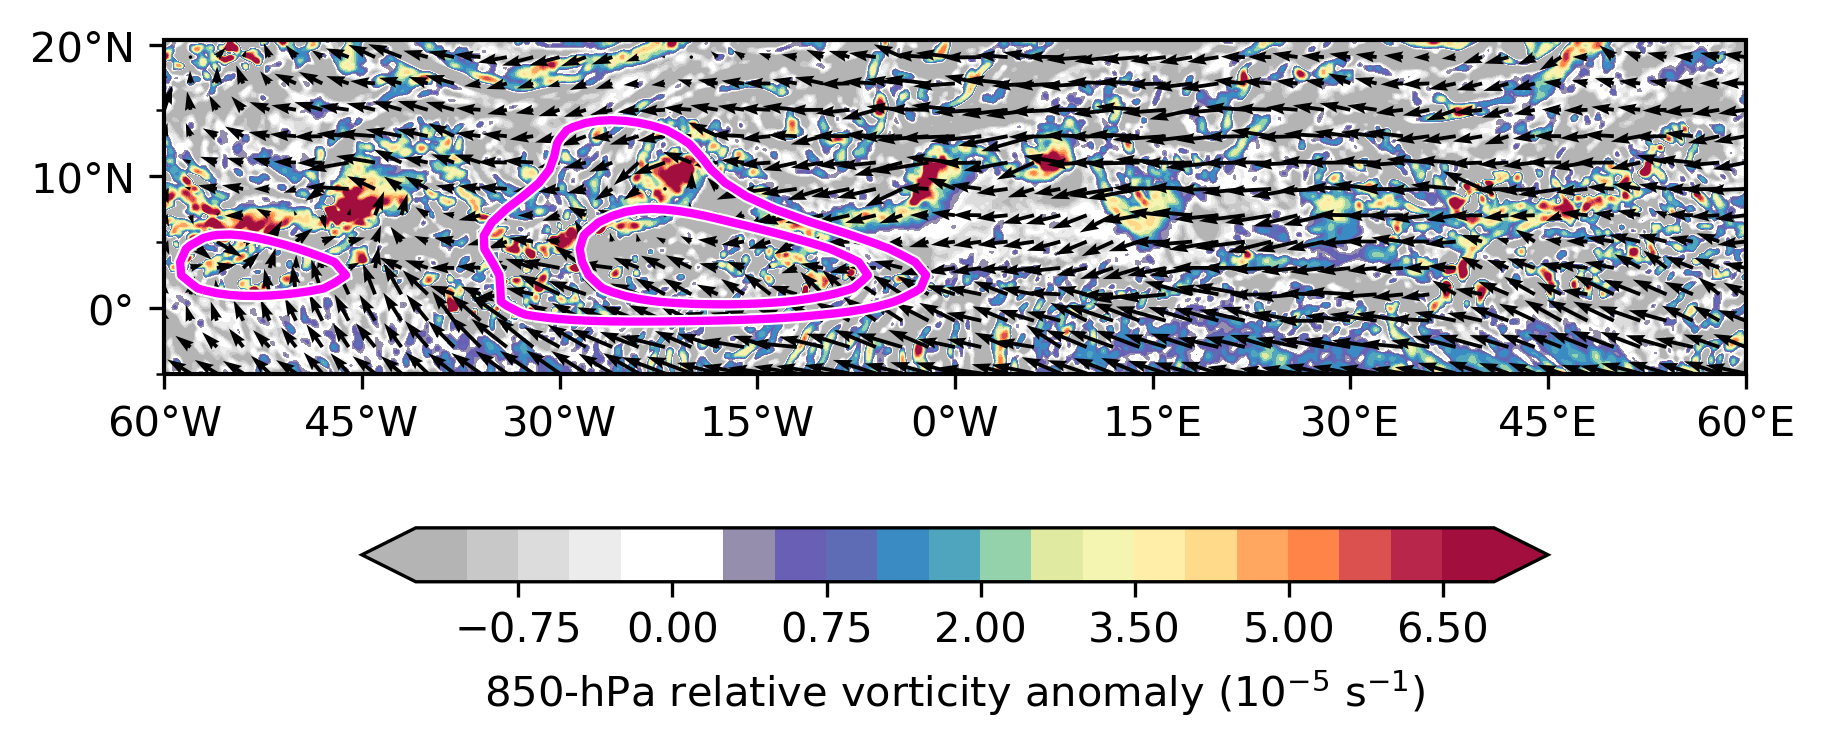

lag: -4.00
<xarray.DataArray ()>
array(-89.093129)
Coordinates:
    lag      float64 -4.0 <xarray.DataArray ()>
array(90.867386)
Coordinates:
    lag      float64 -4.0
<xarray.DataArray ()>
array(-1.144281)
Coordinates:
    lag      float64 -4.0 <xarray.DataArray ()>
array(1.192426)
Coordinates:
    lag      float64 -4.0


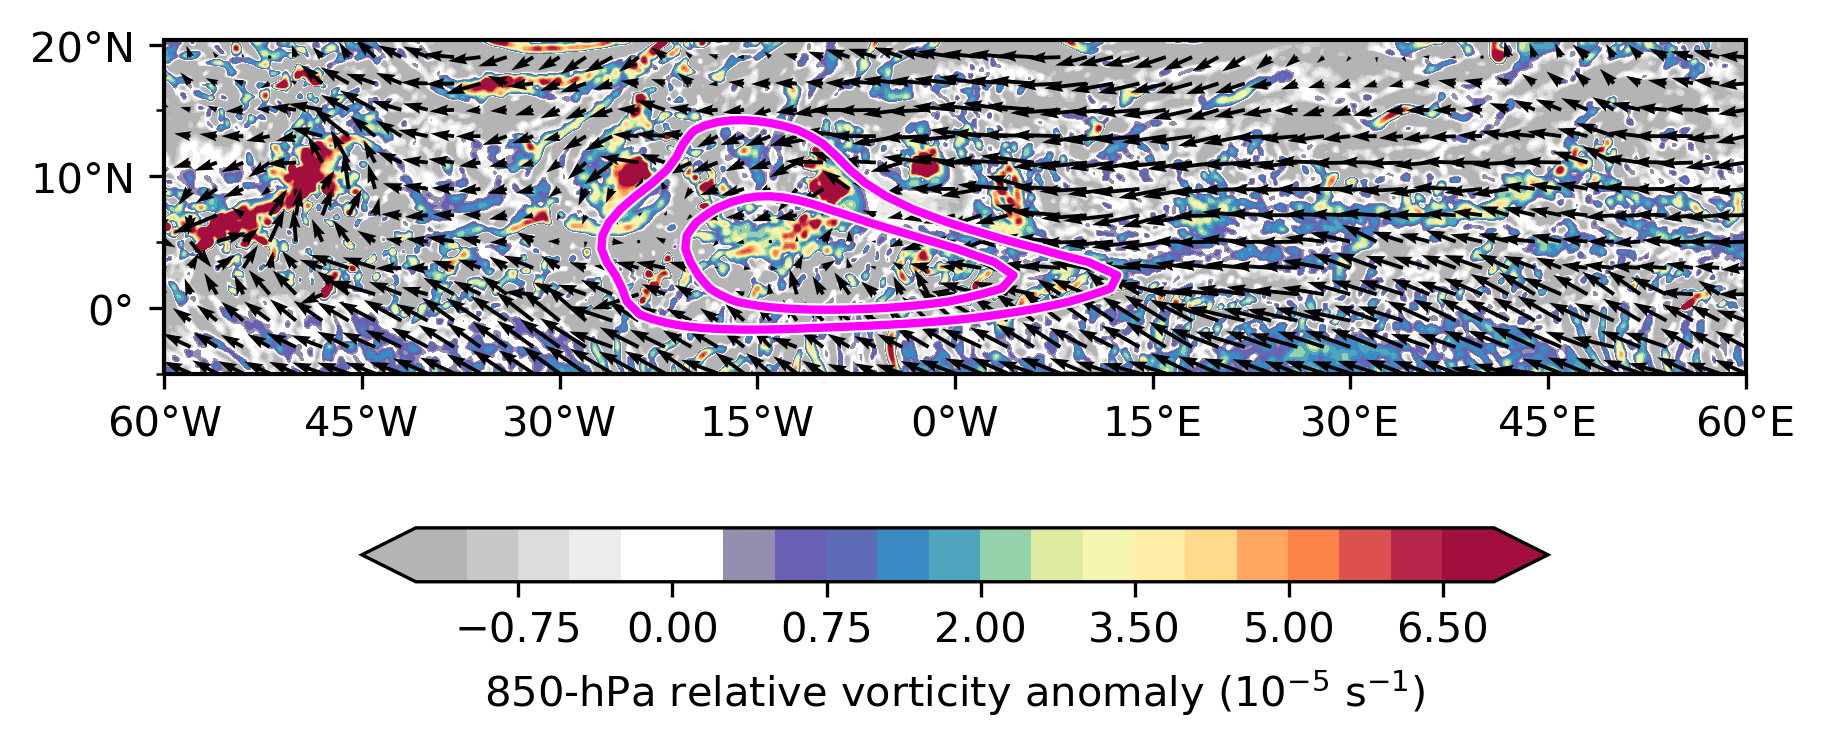

lag: -3.00
<xarray.DataArray ()>
array(-106.594153)
Coordinates:
    lag      float64 -3.0 <xarray.DataArray ()>
array(135.569507)
Coordinates:
    lag      float64 -3.0
<xarray.DataArray ()>
array(-1.191093)
Coordinates:
    lag      float64 -3.0 <xarray.DataArray ()>
array(1.210909)
Coordinates:
    lag      float64 -3.0


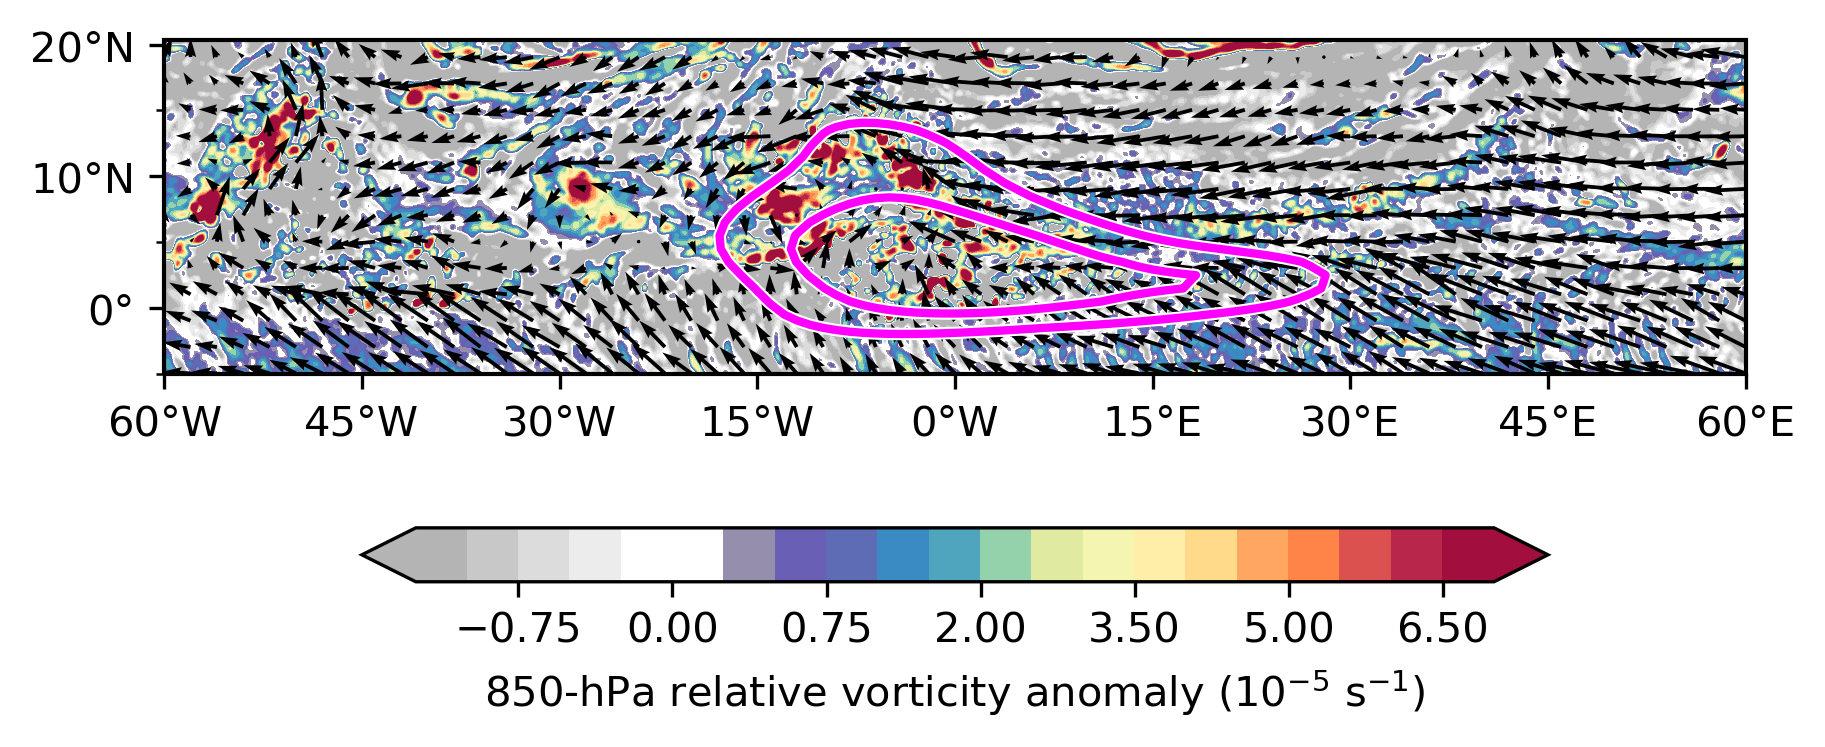

lag: -2.00
<xarray.DataArray ()>
array(-143.160112)
Coordinates:
    lag      float64 -2.0 <xarray.DataArray ()>
array(160.247984)
Coordinates:
    lag      float64 -2.0
<xarray.DataArray ()>
array(-1.032414)
Coordinates:
    lag      float64 -2.0 <xarray.DataArray ()>
array(1.264235)
Coordinates:
    lag      float64 -2.0


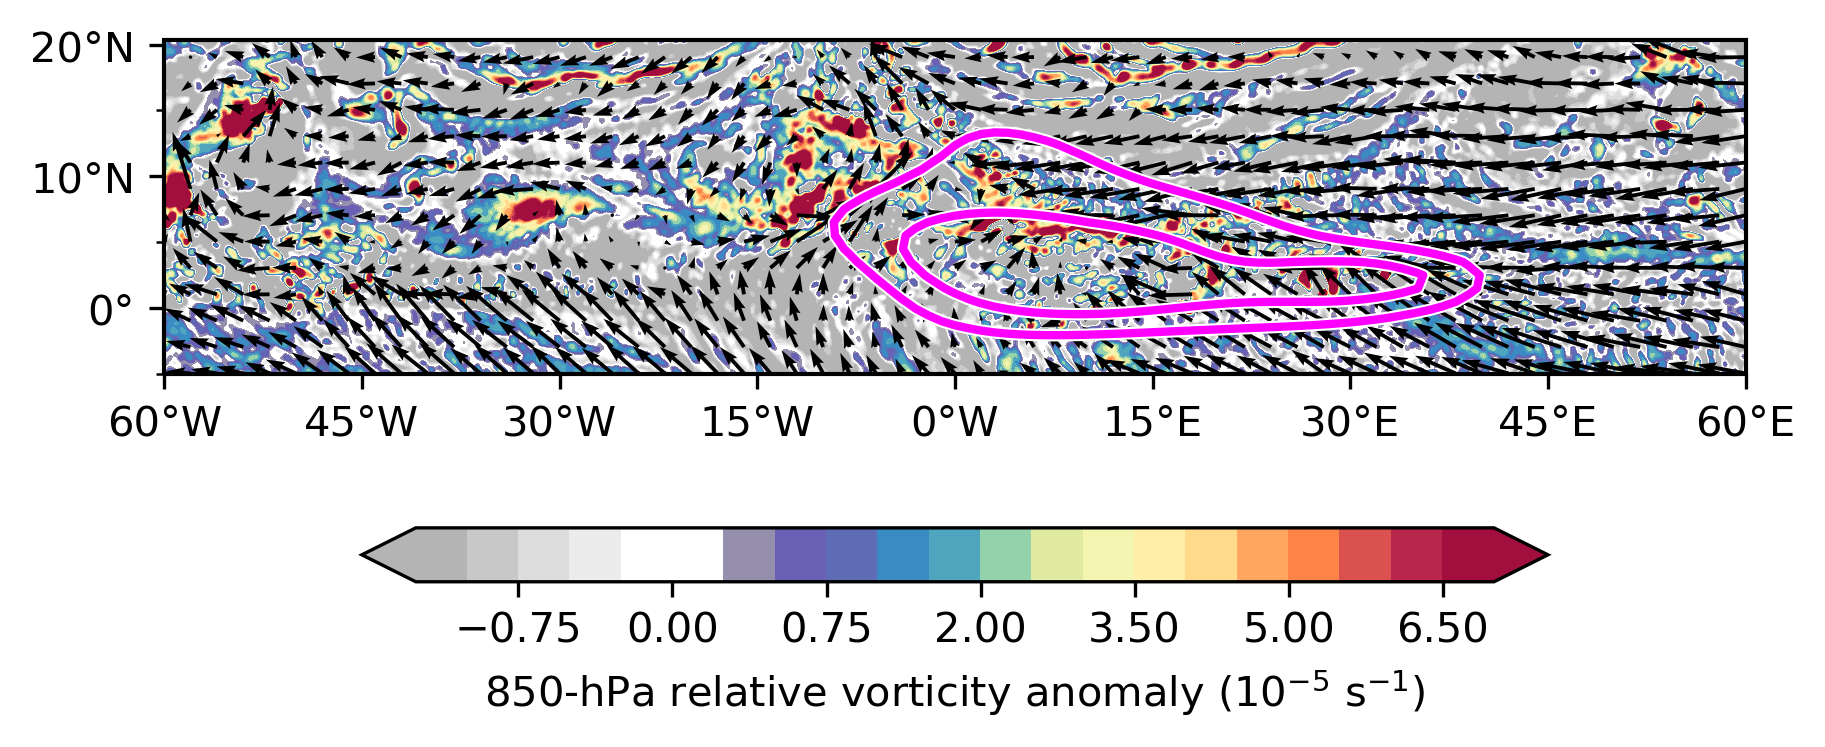

lag: -1.00
<xarray.DataArray ()>
array(-121.659937)
Coordinates:
    lag      float64 -1.0 <xarray.DataArray ()>
array(145.511865)
Coordinates:
    lag      float64 -1.0
<xarray.DataArray ()>
array(-0.714278)
Coordinates:
    lag      float64 -1.0 <xarray.DataArray ()>
array(1.344511)
Coordinates:
    lag      float64 -1.0


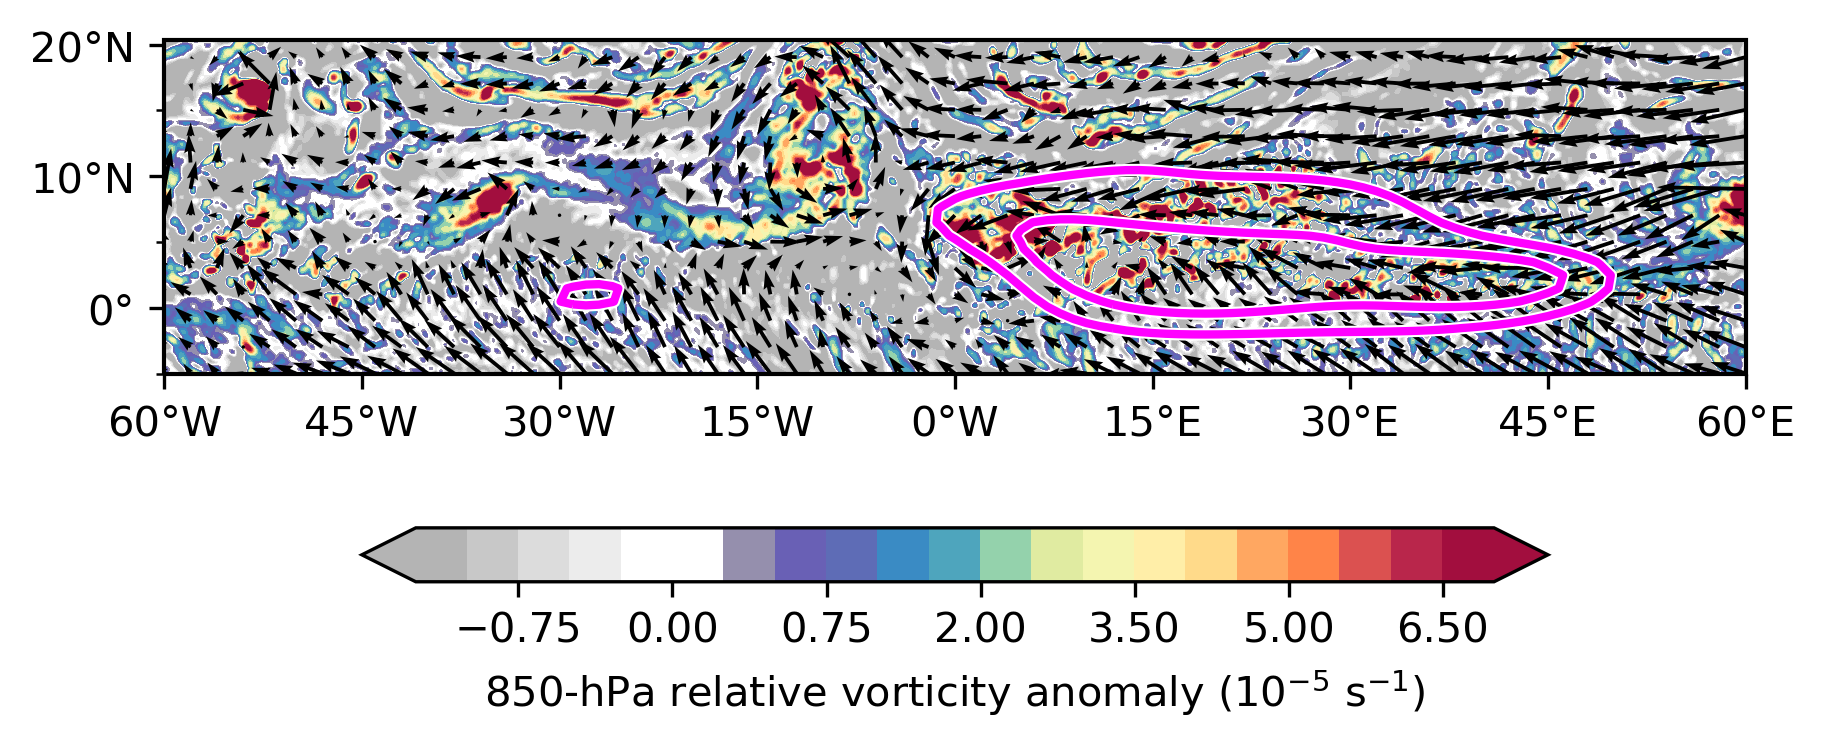

lag: 0.00
<xarray.DataArray ()>
array(-119.565474)
Coordinates:
    lag      float64 0.0 <xarray.DataArray ()>
array(125.044677)
Coordinates:
    lag      float64 0.0
<xarray.DataArray ()>
array(-0.852188)
Coordinates:
    lag      float64 0.0 <xarray.DataArray ()>
array(1.479425)
Coordinates:
    lag      float64 0.0


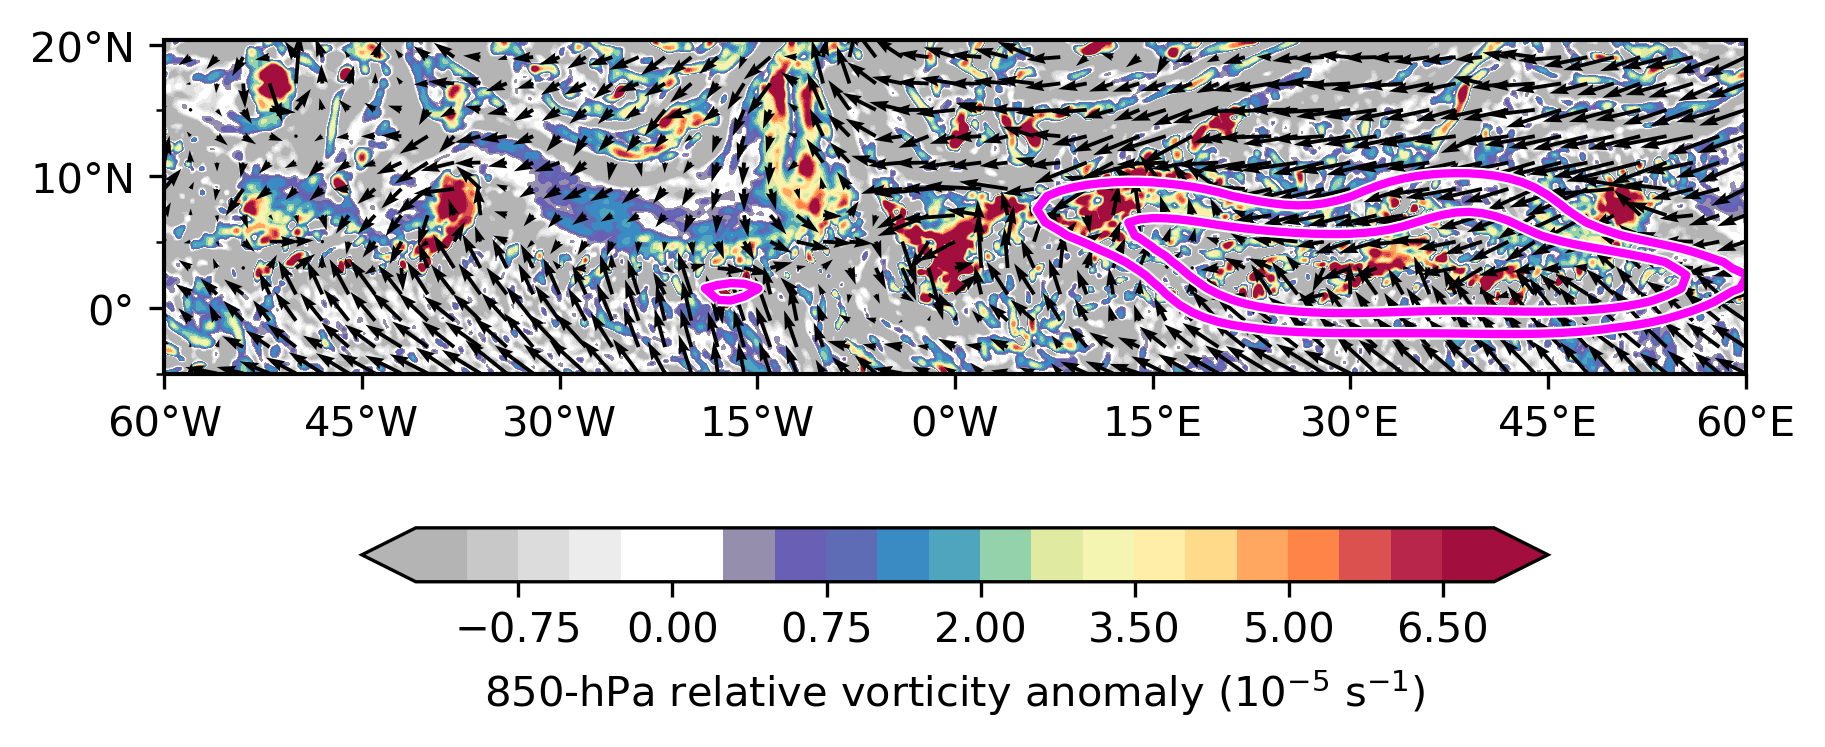

lag: 1.00
<xarray.DataArray ()>
array(-138.616317)
Coordinates:
    lag      float64 1.0 <xarray.DataArray ()>
array(161.233568)
Coordinates:
    lag      float64 1.0
<xarray.DataArray ()>
array(-0.912543)
Coordinates:
    lag      float64 1.0 <xarray.DataArray ()>
array(1.891363)
Coordinates:
    lag      float64 1.0


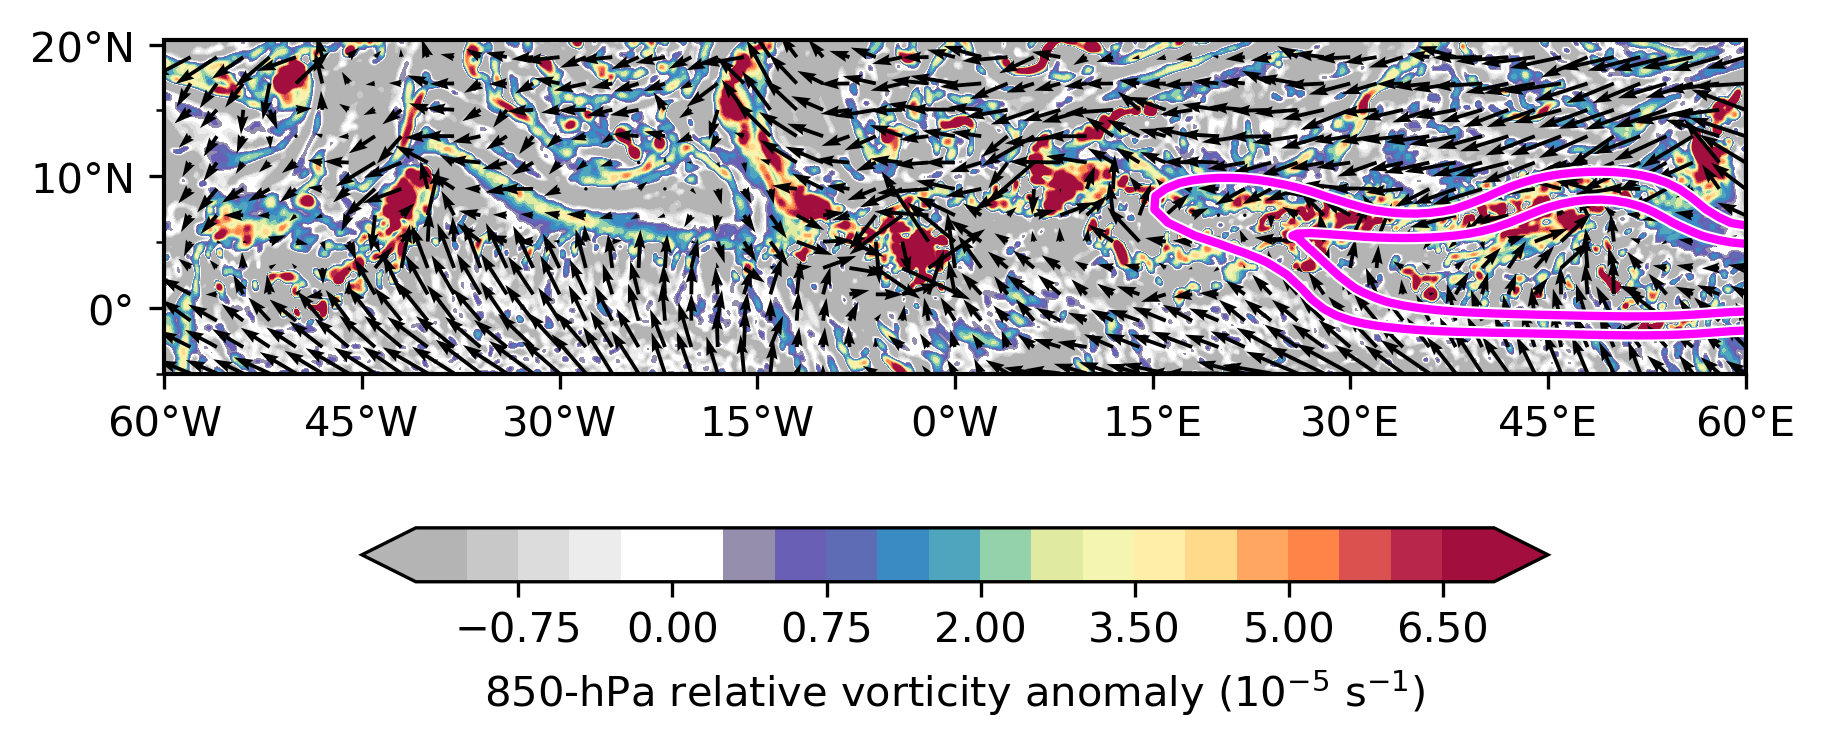

lag: 2.00
<xarray.DataArray ()>
array(-113.543274)
Coordinates:
    lag      float64 2.0 <xarray.DataArray ()>
array(234.902371)
Coordinates:
    lag      float64 2.0
<xarray.DataArray ()>
array(-0.800414)
Coordinates:
    lag      float64 2.0 <xarray.DataArray ()>
array(1.657768)
Coordinates:
    lag      float64 2.0


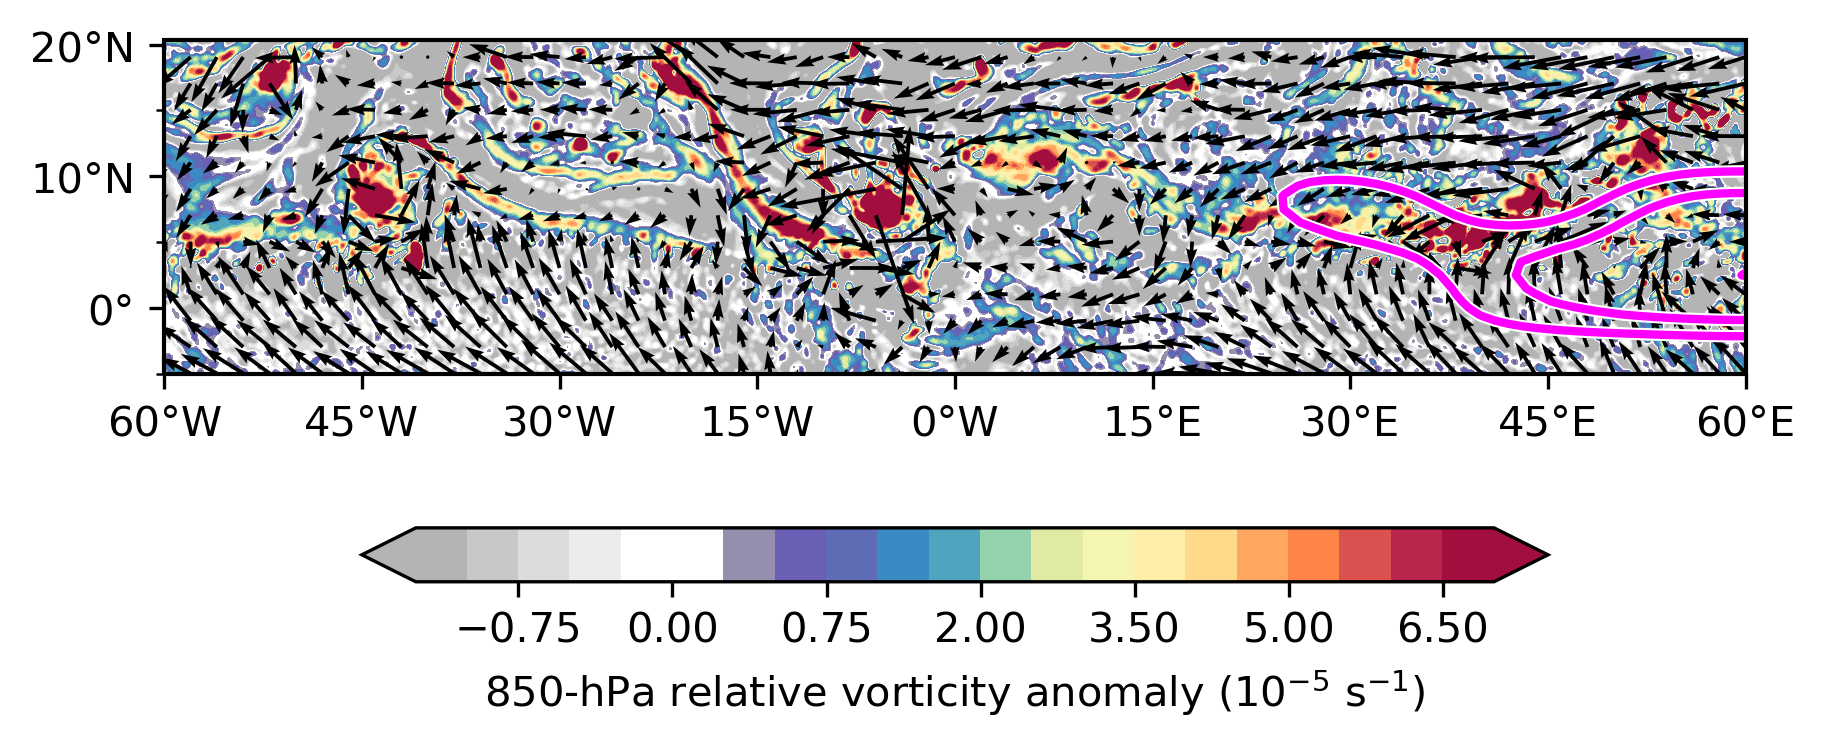

lag: 3.00
<xarray.DataArray ()>
array(-119.751575)
Coordinates:
    lag      float64 3.0 <xarray.DataArray ()>
array(234.11978)
Coordinates:
    lag      float64 3.0
<xarray.DataArray ()>
array(-0.583466)
Coordinates:
    lag      float64 3.0 <xarray.DataArray ()>
array(1.064141)
Coordinates:
    lag      float64 3.0


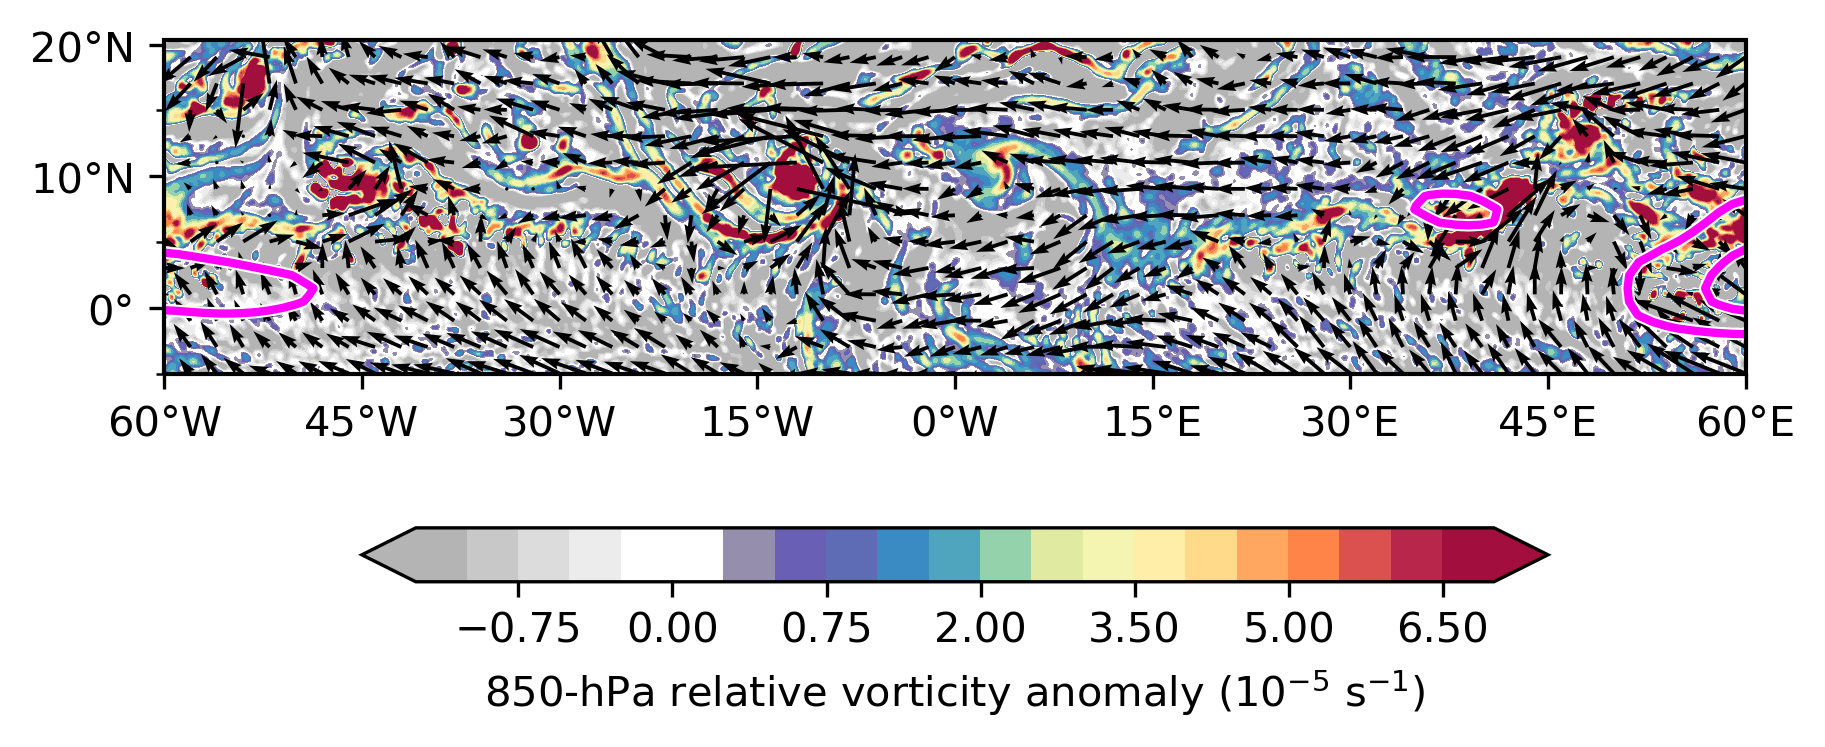

lag: 4.00
<xarray.DataArray ()>
array(-178.708567)
Coordinates:
    lag      float64 4.0 <xarray.DataArray ()>
array(355.983316)
Coordinates:
    lag      float64 4.0
<xarray.DataArray ()>
array(-0.585387)
Coordinates:
    lag      float64 4.0 <xarray.DataArray ()>
array(0.627463)
Coordinates:
    lag      float64 4.0


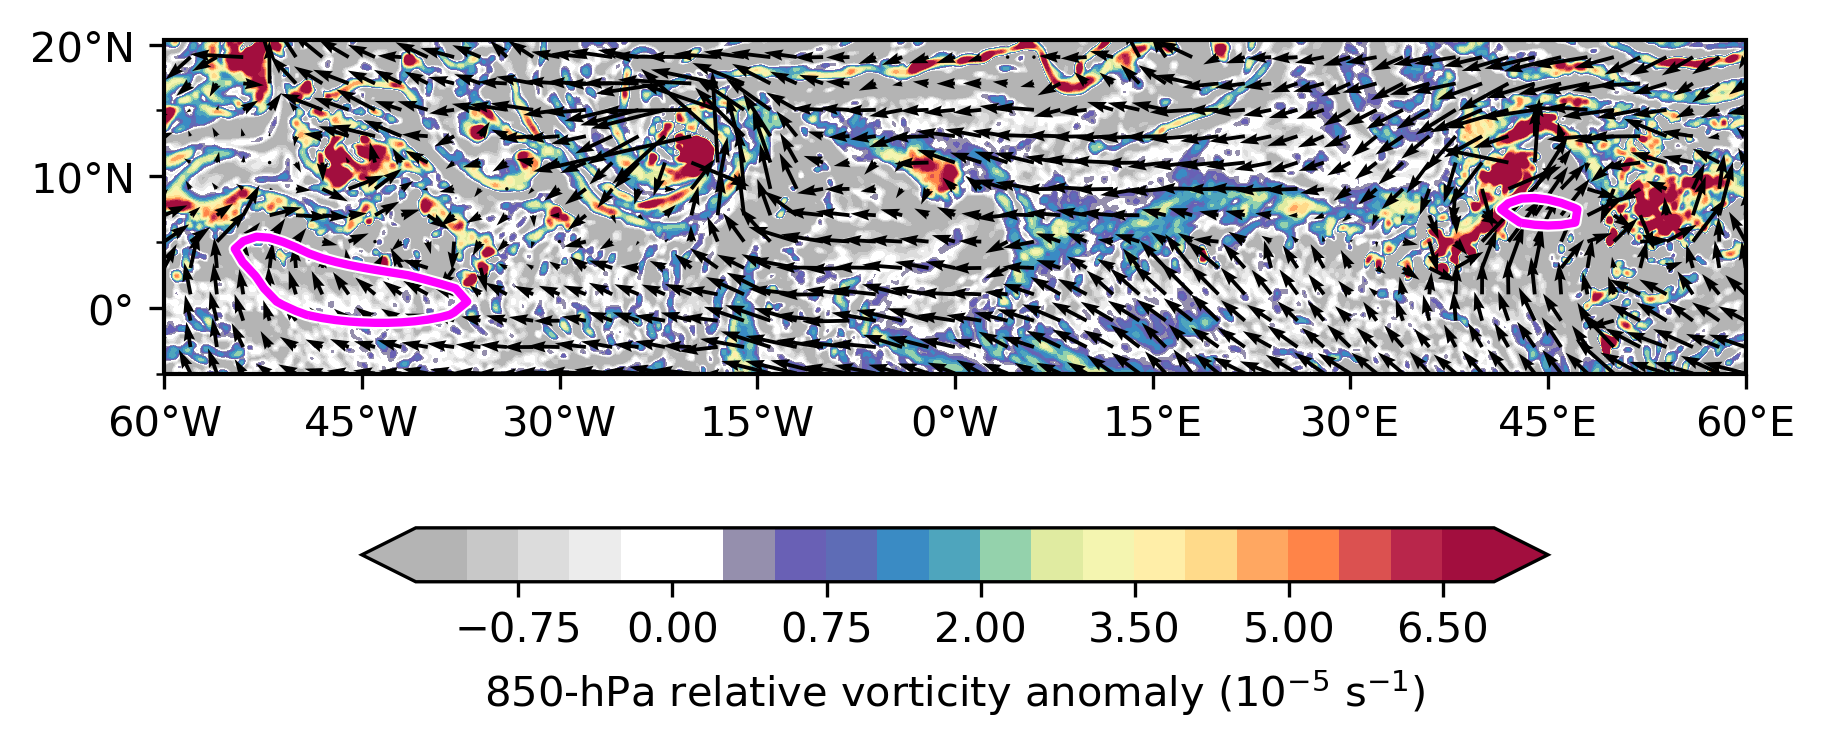

lag: 5.00
<xarray.DataArray ()>
array(-77.732239)
Coordinates:
    lag      float64 5.0 <xarray.DataArray ()>
array(491.57748)
Coordinates:
    lag      float64 5.0
<xarray.DataArray ()>
array(-0.526873)
Coordinates:
    lag      float64 5.0 <xarray.DataArray ()>
array(0.649121)
Coordinates:
    lag      float64 5.0


In [ ]:
#increase font size
plt.rcParams.update({'font.size': 10})

expName='TC_3km'
waveName = 'caseStudy'
level = 0.0
list_of_vars = ['VOR850','u850','v850','filteredpr','filteredprWave2']
list_of_levels = [0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
laggedTimes2Plot = np.arange(-5.0,5.25,1.0)
letterLabels = ['(b)','(d)','(f)','(h)','(j)','(l)']

# uncomment below to plot single time on a single panel 

waveRelativeFields=read_feature_relative_data(expName,waveName,list_of_vars,\
                                                 list_of_levels,laggedTimes2Plot,True,\
                                                minLatPlot=-5,maxLatPlot=20.5,waveName4Plot='TD',\
                                                waveName4Plot2='Kelvin',track_id=6203)

for i in np.arange(0,len(laggedTimes2Plot)):
    laggedTime = laggedTimes2Plot[i]
    print('lag: %2.2f'%laggedTime)
    
    # filteredprWave1 = waveRelativeFields['filteredpr']*0.01
    filteredprWave2 = waveRelativeFields['filteredprWave2'][i,:]
    uwind = waveRelativeFields['u850'][i,:]
    vwind = waveRelativeFields['v850'][i,:]
    
    for varName in [list_of_vars[0]]:
        field1 = waveRelativeFields[varName][i,:]*my_dict[varName][0]
        plot_latlon_waverelative(field1,uwind,vwind,
                                 # field2=filteredprWave1,
                                 field3=filteredprWave2,
                                 panelLabels=False,
                                 cLabel = my_dict[varName][3])#rainfall rate anomaly (mm hr$^{-1}$)')

In [ ]:
#increase font size
plt.rcParams.update({'font.size': 10})

### --------- code for multi-panel plots ------------ ###
expName='TC_3km'
waveName = 'KelvinTCG'

list_of_levels = [0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
list_of_vars = ['pr','VOR850','u850','v850','u200','v200','filteredpr','filteredprWave2']
laggedTimes2Plot = np.arange(-5,1,1)

waveRelativeFields=read_feature_relative_data(expName,waveName,list_of_vars,\
                                                 list_of_levels,laggedTimes2Plot,True,\
                                                minLatPlot=-0.05,maxLatPlot=20.5,waveName4Plot='TD',\
                                                waveName4Plot2='Kelvin')    

uwind = waveRelativeFields['u200']
vwind = waveRelativeFields['v200']
varName='pr'
field1 = waveRelativeFields[varName]*my_dict[varName][0]
plot_multi_panel_latlon_waverelative(laggedTimes2Plot,field1,uwind,vwind,
                                     field2=waveRelativeFields['filteredpr'],
                                     field3=waveRelativeFields['filteredprWave2'],
                                     cLabel = my_dict[varName][3],panelLabels=True)

uwind = waveRelativeFields['u850']
vwind = waveRelativeFields['v850']
varName='VOR850'
field1 = waveRelativeFields[varName]*my_dict[varName][0]
plot_multi_panel_latlon_waverelative(laggedTimes2Plot,field1,uwind,vwind,
                                     field2=waveRelativeFields['filteredpr'],
                                     field3=waveRelativeFields['filteredprWave2'],
                                     cLabel = my_dict[varName][3],panelLabels=True)

## Hovmoller w.r.t. wave peak

Redefine color maps and labels

In [ ]:
my_dict = {
    'pr': [1.0,'YlGnBu', np.logspace(-1,1,21), r'rainfall rate anomaly ($\sigma$)',colors.LogNorm(vmin=0.1, vmax=10.0),'(a) rainfall rate'],
    'filteredpr': [1.0,'Spectral', np.linspace(-2.0,2.0,21), r'filtered rainfall rate anomaly ($\sigma$)',colors.LogNorm(vmin=0.1, vmax=10.0)],
    'u850': [1,'RdBu_r',np.linspace(-5,5,21),r'850-hPa zonal wind anomaly ($\sigma$)','(a) 850-hPa $u$'],
    'v850': [1,'RdBu_r',np.linspace(-3,3,21),r'850-hPa meridional wind anomaly ($\sigma$)','(a) 200-hPa $v$'],
    'u200': [1,'RdBu_r',np.linspace(-10,10,21),r'200-hPa zonal wind anomaly ($\sigma$)','(b) 200-hPa $u$'],
    'v200': [1,'RdBu_r',np.linspace(-10,10,21),r'200-hPa meridional wind anomaly ($\sigma$)','(b) 200-hPa $v$'],
    'precipw': [1,'BrBG',np.linspace(-5.0,5.0,21),r'precipitable water anomaly ($\sigma$)','(a) precipitable water'],
    'mse_vint': [1.0e-6,'coolwarm',np.linspace(-20.0,20.0,21),'<h> (10$^{6}$ J m$^{-2}$)'],
    'ushr': [1,'PuOr',np.linspace(-2.5,2.5,21),'200-850 hPa zonal shear (m s$^{-1}$)'],
    'vshr': [1,'PuOr',np.linspace(-2.5,2.5,21),'200-850 hPa meridional shear (m s$^{-1}$)'],
    'SHRM': [1,'RdBu_r',np.linspace(-4,4,17),r'200-850 hPa shear magnitude (m s$^{-1}$)','(b) shear'],
    'shrmag': [1,'RdBu_r',np.linspace(-2.5,2.5,21),r'200-850 hPa shear magnitude ($\sigma$)','(b) shear'],
    'SHEAR_VOR': [1.0e6,'RdGy_r',np.linspace(-5,5,21),'850-hPa shear vorticity\n anomaly (10$^{-6}$ s$^{-1}$)','(c) vorticity'],
    'CURVATURE_VOR': [1.0e6,'RdGy_r',np.linspace(-5,5,21),'850-hPa curvature vorticity\n anomaly (10$^{-5}$ s$^{-1}$)','(c) vorticity'],
    # 'VOR850': [1.0e5,'RdGy_r',np.linspace(-2.5,2.5,21),'850-hPa relative vorticity\n anomaly (10$^{-5}$ s$^{-1}$)','(c) vorticity'],
    'VOR200': [1.0e5,'RdGy_r',np.linspace(-1.0,1.0,21),'200-hPa relative vorticity\n anomaly (10$^{-5}$ s$^{-1}$)','(c) vorticity'],
    'VOR850': [1.0e5,defineColormap('vorticity'),np.array([-3,-2,-1.5,-1.0,-0.5,0,0.5,1,1.5,2,3,4,5,6,7,8,9,10,11,12,13,14])*0.2,'850-hPa relative vorticity\n anomaly (10$^{-5}$ s$^{-1}$)','(c) vorticity'],
    # 'VOR200': [1.0e5,defineColormap('vorticity'),np.array([-3,-2,-1.5,-1.0,-0.5,0,0.5,1,1.5,2,3,4,5,6,7,8,9,10,11,12,13,14])*0.1,'200-hPa relative vorticity\n anomaly (10$^{-6}$ s$^{-1}$)','(c) vorticity'],
    'circ_vint': [1.0e5,'RdGy',np.linspace(-3.5,3.5,21),'vertically-integrated circulation anomaly (10$^{-5}$ s$^{-1}$)'],
    'qv500':[1000.0,'BrBG',np.linspace(-0.6,0.6,21),'500-hPa water vapor mixing ratio (g kg$^{-1}$)'],
    'SAT_FRACTION':[1.0,'BrBG',np.linspace(-0.1,0.1,21),'saturation fraction anomaly'],
    'RHUM':[1.0,'BrBG',np.linspace(-10.0,10.0,21),r'600-hPa relative humidity anomaly ($\sigma$)','(b) 600-hPa RH' ],
    'hfx': [1.0,'RdBu_r',np.linspace(-10,10,21),'surface sensible heat flux (W m$^{-2}$)'],
    'qfx': [2.5e6,'RdBu_r',np.linspace(-20,20,21),'surface latent heat flux (W m$^{-2}$)'],
    'CI': [1.0,'RdBu_r',np.linspace(-1.25,1.25,21),'coupling index (K)'],
    'olrtoa': [1.0,'RdBu_r',np.linspace(-75,75,21),'outgoing longwave radiation anomaly (W m$^{-2}$)'],
    'SF' : [1.0,'RdBu_r',np.linspace(-10,10,21),'surface heat fluxes anomaly (W m$^{-2}$)'],
    'R' : [1.0,'RdBu_r',np.linspace(-10,10,21),'radiative fluxes anomaly (W m$^{-2}$)'],
    'VI' : [1.0,'RdBu_r',np.linspace(-0.08,0.08,17),r'ventilation index anomaly','(a) ventilation'],
    'MPI_VMAX' : [1.0,'RdBu_r',np.linspace(-3.0,3.0,21),r'MPI anomaly (m s$^{-1}$)','(d) PI'],
    'AIRSEA' : [1.0,'RdBu_r',np.linspace(-20,20,21),r'entropy deficit anomaly ($\sigma$)','(c) entropy deficit'],
    'GPI_E' : [1.0e14,'PRGn',np.linspace(-0.4,0.4,21),'GPI anomaly (10$^{-14})$','(c) entropy deficit'],
    'CHI_TE' : [1.0,'RdBu_r',np.linspace(-0.4,0.4,21),'entropy deficit anomaly','(c) entropy deficit'],
    'CHI_NUM' : [1.0,'RdBu_r',np.linspace(-0.025,0.025,21),r'entropy deficit anomaly ($\sigma$)','(c) entropy deficit'],
    'DIV200': [1.0e6,'PRGn',np.linspace(-9,9,21),'200-hPa divergence\nanomaly (10$^{-6}$ s$^{-1}$)','(d) divergence'],
    'DIV850': [1.0e6,'PRGn',np.linspace(-3,3,21),'850-hPa divergence\nanomaly (10$^{-6}$ s$^{-1}$)','(d) divergence'],
    'divlo': [1.0e5,'RdGy',np.linspace(-1.5,1.5,21),'850$-$1000-hPa divergence anomaly (10$^{-5}$ s$^{-1}$)'],
    'u200Yang': [1.0,'RdBu_r',np.linspace(-2.5,2.5,21),'200-hPa filtered zonal wind (m s$^{-1}$)',''],
    'u850Yang': [1.0,'RdBu_r',np.linspace(-2,2,21),'850-hPa filtered zonal wind (m s$^{-1}$)',''],
    'v850Yang': [1.0,'RdBu_r',np.linspace(-10,10,21),'850-hPa filtered meridional wind (m s$^{-1}$)',''],
    'logVI' : [1.0,'YlGnBu',np.linspace(-0.05,0.05,21),r'$\ln$(ventilation index)','(a) ventilation'],
    'logMPI_VMAX' : [1.0,'Blues',np.linspace(-0.05,0.05,21),r'$\ln$(ventilation index)','(a) ventilation'],
    'logCHI_TE' : [1.0,'Greens',np.linspace(-0.05,0.05,21),r'$\ln$(ventilation index)','(a) ventilation'],
    'logCHI_NUM' : [1.0,'Greens',np.linspace(-0.05,0.05,21),r'$\ln$(ventilation index)','(a) ventilation'],
    'logAIRSEA' : [1.0,'Greens',np.linspace(-0.05,0.05,21),r'$\ln$(ventilation index)','(a) ventilation'],
    'logSHRM' : [1.0,'Oranges',np.linspace(-0.05,0.05,21),r'$\ln$(ventilation index)','(a) ventilation'],
}

Define function that reads hovmoller data and creates a quick look.

In [ ]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

def format_valid_time(dfIn):
    time = []
    for index, row in dfIn.iterrows():
        ctim = np.datetime64(pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S'))
        time.append(ctim) 
    dfIn['time']=time
    return dfIn

def get_plot_waverelative_hovmoller(expName,waveName,list_of_vars,**kwargs):
    
    if 'panelLabels' not in kwargs:
        kwargs['panelLabels'] = False
        
    # set global parameters -- should these be input to the function?
    dLon = 45.0
    nDays = 7
    
    #increase font size
    plt.rcParams.update({'font.size': 18})
    
    fname = pth+expName+'/latlon/diags_gaussian_global_nospinup_r3600x1800.nc'
    
    if ('allTCG' in waveName):
        # find the TCG locations
        tcgen_info = pd.read_csv('TCG_TC_3km.csv')
        tcgen_info = tcgen_info[tcgen_info.lat <= 20]
        lon = tcgen_info.lon.values
        time = []
        for index, row in tcgen_info.iterrows():
            ctim = np.datetime64(pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S'))
            time.append(ctim)  
        # number of points to skip
        skip=1
    elif (waveName=='KelvinTCG'):
        tcgen_info = pd.read_csv('Kelvin_TCG_on_peak_TempestExtremes.csv')#,parse_dates=['time'])
        tcgen_info = tcgen_info[tcgen_info.lat <= 20]
        lon = tcgen_info.lon.values
        time = []
        for index, row in tcgen_info.iterrows():
            ctim = np.datetime64(pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S'))
            time.append(ctim)  
        # number of points to skip
        skip=1
    elif (waveName =='notKelvinTCG'):
        tcgen_info = pd.read_csv('Kelvin_TCG_not_on_peak.csv')#,parse_dates=['time'])
        tcgen_info = tcgen_info[tcgen_info.lat <= 20]
        lon = tcgen_info.lon.values
        time = []
        for index, row in tcgen_info.iterrows():
            ctim = np.datetime64(pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S'))
            time.append(ctim)  
        # number of points to skip
        skip=1
    elif ('TDTCG' in waveName):
        tcgen_info = pd.read_csv('TD_TCG_on_peak.csv')#,parse_dates=['time'])
        tcgen_info = tcgen_info[tcgen_info.lat <= 20]
        lon = tcgen_info.lon.values
        time = []
        for index, row in tcgen_info.iterrows():
            ctim = np.datetime64(pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S'))
            time.append(ctim)
        # number of points to skip
        skip=1
    else:
        #check if I have already saved the filtered wave data
        waveFile = pth+expName+'/latlon/'+waveName+'_r3600x1800.csv'
        if os.path.exists(waveFile):
            df = pd.read_csv(waveFile)
            lon=df.lon.values
            time=[]
            for index, row in df.iterrows():
                ctim = np.datetime64(pd.to_datetime(row['time'],format='%Y-%m-%d %H:%M:%S'))
                time.append(ctim) 
        else:
            fname = pth+expName+'/latlon/diags_gaussian_global_nospinup_r3600x1800.nc'
            lon, time, _, _ = find_wave_peak_graphically(fname,waveName)
            #save file for future use
            data2save = {
                'lon':  lon,
                'time': [t.values for t in time]
            }
            df=pd.DataFrame(data2save)
            df.to_csv(waveFile,index=False)
        skip=10
        # lon, time, waveData, waveDatadt = find_wave_peak_graphically(fname,waveName)
        # # normalize
        # waveData = waveData/waveData.std(dim=('time'))
        # waveDatadt = waveDatadt/waveDatadt.std(dim=('time'))
        # waveData = waveData.where( (waveData**2.0+waveDatadt**2.0)**0.5 >= 1.0 )
        
    # read TCs info if we're considering wave analyses
    tcRemoval=True
    if ('TCG' not in waveName) & (tcRemoval):
        # load file with TC genesis info
        tcgen_info = pd.read_csv('TCG_TC_3km_35N1tstepwarmcore_unstructuredmesh.csv')
        # limit TCG to eq. of 20N
        tcgen_info = tcgen_info[tcgen_info.lat<=20]
        # format valid time
        tcgen_info = format_valid_time(tcgen_info)
        print(len(tcgen_info.ID.unique()))

        # load file with ALL TCs
        exp_name = 'TC_3km'
        pth2tracks = '/glade/scratch/rberrios/projects/ongoing/TCgenesis_mpas_aqua/TC_tracks/TC_3km/VORT_vertmean_n256/post_processed/'
        df_all = pd.read_csv(
            '%sTRACK_data_all_REFINED_CENTER_3km_35N1tstepwarmcore.csv'%pth2tracks)
        df_all=df_all.rename(columns={'lon_pcentroid_pmin_r100':'lon','lat_pcentroid_pmin_r100':'lat'})
        print(len(df_all.ID.unique()))
        # keep only the TCs that undergo genesis & points of at least H1 strength
        df_TCs = df_all[df_all.ID.isin(tcgen_info.ID.unique()) & (df_all.vmax >= 33.0) & (df_all.lat >= minLat) & (df_all.lat <= maxLat+5.0)]
        #format valid time
        df_TCs = format_valid_time(df_TCs)
        print(len(df_TCs.ID.unique()))

        # filter out TCs from the 
        waveLons = lon[0:-1:skip] #choose only some waves for now; randomnized later on
        waveTime = time[0:-1:skip]
        waveLonsNoTCs = []
        waveTimeNoTCs = []
        print('no. wave peaks: %i'%len(waveLons))
        print('removing times with TCs')
        for d in np.arange(0,len(waveLons)):

            tcsAtThisTime = df_TCs[(df_TCs.time>=waveTime[d]-pd.to_timedelta(nDays,unit='D')) & (df_TCs.time<=waveTime[d]+pd.to_timedelta(nDays,unit='D'))]
            # check if any of these TCs are within the wave boundary
            tcFlag = False
            for index, row in tcsAtThisTime.iterrows():
                if (row['lon'] >= waveLons[d]-dLon) & (row['lon'] <= waveLons[d]+dLon):
                    tcFlag = True
                    break
            if (tcFlag == False):                
                waveLonsNoTCs.append(waveLons[d])
                waveTimeNoTCs.append(waveTime[d])

        waveLons = waveLonsNoTCs
        waveTime = waveTimeNoTCs
    else:
        waveLons = lon[0:len(lon):skip] #choose only some waves for now; randomnized later on
        waveTime = time[0:len(time):skip]
    print('no. wave peaks: %i'%len(waveLons))
    
    output = {}
    for varName in list_of_vars:
        print(varName)
        
        #check if we need filtered data for a second wave
        if ('filtered' in varName):

            if (kwargs['waveName2'] != waveName):
                _, _, waveData2, waveDatadt2 = find_wave_peak_graphically(fname,kwargs['waveName2'])
                # normalize
                print('NORMALIZING')
                waveData2 = waveData2/waveData2.std(dim=('time'))
                # waveDatadt2 = waveDatadt2/waveDatadt2.std(dim=('time'))
            else:
                _, _, waveData, waveDatadt = find_wave_peak_graphically(fname,kwargs['waveName2'])
                # normalize
                print('NORMALIZING')
                waveData = waveData/waveData.std(dim=('time'))
                # waveDatadt = waveDatadt/waveDatadt.std(dim=('time'))
                waveData2 = waveData

            # waveData2 = waveData2.where( (waveData2**2.0+waveDatadt2**2.0)**0.5 >= 1.0 )


        ds = xr.open_dataset(fname).sel(lat=slice(minLat,maxLat))

        dx = np.abs(ds.lon[1].values-ds.lon[0].values)

        lon_array_target = xr.DataArray(np.arange(-dLon,dLon+dx,dx))
        tim_array_target = xr.DataArray(np.arange(-nDays,nDays+0.25,0.25))

        centered_data_0s = np.empty( (len(waveLons),len(tim_array_target),len(lon_array_target)) )
        centered_data_0s[:] = np.nan
        IDs = np.arange(0,len(waveLons))

        ds_out = xr.DataArray(centered_data_0s,dims=('ID','time','lon'),coords=(IDs,tim_array_target,lon_array_target))

        if ('filtered' in varName):
            if kwargs['waveName2'] == waveName:
                varAllTimes = waveData
            else:
                # lon2, time2, waveData = find_wave_peak_graphically(fname,kwargs['waveName2'])
                varAllTimes = waveData2 
        else:
            if (varName == 'SAT_FRACTION'):
                varAllTimes = (ds.qv_vint/ds.qvs_vint).mean('lat')
            elif (varName == 'SHEAR_VOR'):
                Rearth = 6379.0e3
                uwind = ds.u850
                vwind = ds.v850
                U = (uwind**2.0 + vwind**2.0)**0.5
                x = np.radians(U.lon)*Rearth
                y = np.radians(U.lat)*Rearth
                dudx = np.gradient(uwind,x,axis=2)
                dudy = np.gradient(uwind,y,axis=1)
                dvdx = np.gradient(vwind,x,axis=2)
                dvdy = np.gradient(vwind,y,axis=1)
                varAllTimes = ((U**(-2.0))*( (vwind*uwind*dudx) +\
                                            (vwind*vwind*dvdx) -\
                                            (uwind*uwind*dudy) -\
                                            (uwind*vwind*dvdy))).mean('lat')
            elif (varName == 'CURVATURE_VOR'):
                Rearth = 6379.0e3
                uwind = ds.u850
                vwind = ds.v850
                U = (uwind**2.0 + vwind**2.0)**0.5
                x = np.radians(U.lon)*Rearth
                y = np.radians(U.lat)*Rearth
                dudx = np.gradient(uwind,x,axis=2)
                dudy = np.gradient(uwind,y,axis=1)
                dvdx = np.gradient(vwind,x,axis=2)
                dvdy = np.gradient(vwind,y,axis=1)
                varAllTimes = ((U**(-2.0))*( (uwind*uwind*dudx) -\
                                            (vwind*vwind*dudy) -\
                                            (uwind*uwind*dudx) +\
                                            (uwind*vwind*dvdy))).mean('lat')
            elif ('VI' in varName) | ('SHRM' in varName) |\
                     ('CHI_TE' in varName) | ('MPI_VMAX' in varName) | \
                     ('AIRSEA' in varName) | ('CHI_NUM' in varName) | \
                     (varName == 'RHUM') | ('VOR' in varName) | ('DIV' in varName):
                del(ds)
                ds = xr.open_dataset(pth+expName+'/latlon/genesis_indexes_r3600x1800_revised_04042023.nc').sel(lat=slice(minLat,maxLat))
                if ('CHI_NUM' in varName):
                    ds['CHI_NUM'] = ds.SPMS-ds.SPM
                    print(ds)
                if ('log' in varName):
                    tmpVar = ds[varName.split('log')[1]]
                    tmpVar = tmpVar.where(np.fabs(tmpVar) > 0.0)
                    varAllTimes = np.log(tmpVar).mean('lat')
                    if ('MPI' in varName): #we need to multiply by -1 bc -ln(MPI)
                        varAllTimes = -1.0*varAllTimes
                else:
                    varAllTimes = ds[varName].mean('lat')
            elif (varName == 'GPI_E'):
                del(ds)
                ds = xr.open_dataset(pth+expName+'/latlon/genesis_indexes_r360x180.nc').sel(lat=slice(minLat,maxLat))
                print(ds.lat.min(),ds.lat.max())
                #calculate the GPI from Emanuel (2010), except using CHI from the ventilation index
                MPI = ds.MPI_VMAX
                CHI = ds.CHI_TE
                VOR = ds.VOR850
                # # smooth out vorticity
                # sigma=5.0
                # VOR = xr.DataArray(sp.ndimage.filters.gaussian_filter(VOR, sigma, mode='constant'),coords=VOR.coords,dims=VOR.dims)
                # # make test plot
                # fig=plt.figure()
                # plt.contourf(VOR.mean('time'))
                # display(fig)
                # we need absolute vorticity
                fcor = 2.0*7.292e-5*np.sin(np.radians(VOR.lat))
                VOR = VOR+fcor
                SHR = ds.SHRM
                # restrict to positive vorticity and non-zero CHI_TE
                VOR = VOR.where(VOR>0.0)
                CHI = CHI.where(CHI>0.0)
                # restrict to MPI - 35 > 0
                MPI = MPI-35.0
                MPI = MPI.where(MPI>0.0,0.0)
                # add 25 m/s to shear
                SHR = SHR+25.0
                GPI = ((np.fabs(VOR)**3.0) * (CHI**(-4.0/3.0)) * (MPI**3.0))/(SHR**4.0)
                varAllTimes = GPI.mean('lat')
                del(VOR,SHR,MPI,CHI)
            elif ('STRETCHING' in varName):
                del(ds)
                plev = varName[10:13]
                ds = xr.open_dataset(pth+expName+'/latlon/genesis_indexes_r3600x1800_revised_04042023.nc').sel(lat=slice(minLat,maxLat))
                fCor = 2.0*7.292e-5*np.sin(np.radians(ds.lat))
                absVOR = ds['VOR%s'%plev]+fCor
                varAllTimes = -1.0*(absVOR*ds['DIV%s'%plev]).mean('lat')
            elif ('Yang' in varName):
                del(ds)
                fname = pth+expName+'/latlon/diags_gaussian_global_nospinup_r3600x1800.nc'
                ds=xr.open_dataset(fname).sel(lat=slice(minLat,maxLat))
                # we want filtered winds using the YHS method
                plev = varName[1:4]
                uname = 'u'+plev
                vname = 'v'+plev
                # assuming it's the same wave
                print('filtering')
                uWave, vWave, zWave = filter_data_for_ccews_YHSmethod(fname,uname,vname,'z',obsPerDay,kwargs['waveName2'])
                print(uWave.min(),uWave.max())
                if (kwargs['waveName2'] == 'Kelvin'):
                    varAllTimes = uWave.sel(lat=slice(minLat,maxLat)).mean('lat')
                    print(varAllTimes.min(),varAllTimes.max())
                elif (kwargs['waveName2'] == 'WMRG'):
                    varAllTimes = vWave.sel(lat=0,method='nearest')
                elif (kwargs['waveName2'] == 'ER1'):
                    varAllTimes = vWave.sel(lat=8,method='nearest')
                elif (kwargs['waveName2'] == 'ER2'):
                    varAllTimes = vWave.sel(lat=13,method='nearest')
                else:
                    print('decide which variable to plot for other waves')
            elif (varName == 'P2'):
                ds = xr.open_dataset(pth+expName+'/latlon/genesis_indexes_r3600x1800_revised_04042023.nc').sel(lat=slice(minLat,maxLat))
                VI = ds['VI'].mean('lat')
                VI0 = VI.mean('time').mean('lon')
                print(VI0)
                alpha=0.5
                varAllTimes = 100.0*(1.0/( (1.0+(VI0/VI)**(-1.0/alpha)) ))
                print(varAllTimes.min(),varAllTimes.max())
            else:
                varAllTimes = ds[varName].mean('lat')

        #subtract the time and zonal mean
        normalize = False
        if ('filtered' not in varName) & ('Yang' not in varName) & ('log' not in varName):# & ('P2' not in varName):
            stddev = varAllTimes.std()
            if (normalize):
                varAllTimes = (varAllTimes - varAllTimes.mean('time').mean('lon'))/stddev
            else:
                varAllTimes = (varAllTimes - varAllTimes.mean('time').mean('lon'))

        #loop through data, obtain datetime object for valid time, and get corresponding index
        d = 0
        for d in np.arange(0,len(waveLons)):
            clon = waveLons[d]        
            #enter code here to check if time and longitude correspond to TCG

            #we'd like to save nx x ny data points, but in some cases the points may be too close to the boundarys
            tim1 = waveTime[d]-pd.to_timedelta(nDays,unit='D')
            tim2 = waveTime[d]+pd.to_timedelta(nDays,unit='D')
            lon1 = clon-dLon
            lon2 = clon+dLon
            
            #choose variable
            var2tst = varAllTimes.sel(time=slice(tim1,tim2))

            #transform time relative to feature time
            var2tst['time'] = (var2tst.time-waveTime[d])/np.timedelta64(1,'D')
            tim_rel = tim_array_target.where( (tim_array_target>=var2tst.time.min()) & (tim_array_target<=var2tst.time.max()) )

            # check if the arrays in and out have consistent time dimensions
            # if not, we're too close to one of the edges. we'd like to skip this time
            tout1 = tim_rel.argmin().values
            tout2 = tim_rel.argmax().values+1
            if ( (tout2-tout1) == len(var2tst.time)):

                #transform longitude to be centered on the feature
                var2tst['lon'] = var2tst.lon-ds.lon.sel(lon=clon,method='nearest')

                # flip if necessary along the cyclic point
                if (var2tst.lon.max() < lon_array_target.max()):
                    #need to find lon<-180 and add 360
                    lon_temp = var2tst.lon.where(var2tst.lon>-180.0,var2tst.lon+360.0)
                    #reassign longitude coordinate
                    var2tst['lon'] = lon_temp
                    #pivot around longitude 0 by finding longitudes <=0 and those > 0
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    #make sure that the coordinate is in ascending order
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    #finally merge the two!
                    var2tst = xr.concat([group1,group2],dim='lon')
                elif (var2tst.lon.min() > lon_array_target.min() ):
                    lon_temp = var2tst.lon.where(var2tst.lon<180.0,var2tst.lon-360.0)
                    var2tst['lon'] = lon_temp
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    group1 = group1.sortby(group1.lon)
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    var2tst = xr.concat([group1,group2],dim='lon')

                var_intrp = var2tst.sel(lon=slice(-(dLon+dx/2),dLon+dx/2))

                ds_out[d,tout1:tout2,:] = var_intrp.values
            else:
                print('skipping because we are too close to the beginning or end of the time period')
                print(tout1,tout2,len(var2tst.time))

            # plt.figure()
            # plt.contourf(ds_out[d,:,:])
            # plt.title(d)
            # break
        print(d)

        centered_data_avg = ds_out.mean(dim='ID')
        output[varName] = centered_data_avg
        del(ds_out)

        #subtract time, zonal mean
        #centered_data_avg = my_dict[varname][0]*(centered_data_avg)
        # centered_data_avg = centered_data_avg-centered_data_avg.mean()
        print(centered_data_avg.min(),centered_data_avg.max())

    # #     with open('test_%s_%s.npy'%(exps[n],varname), 'wb') as f:
    # #         np.save(f,centered_data_avg)

        if ('filtered' in varName):
            with open(pth+expName+'/latlon/saved_composites/%s_waves_composite_hovmoller_%s_%s_MPAS_%s_aqua_sstmax10N.npy'%(waveName,varName,kwargs['waveName2'],expName), 'wb') as f:
                np.save(f,centered_data_avg)
        else:
            with open(pth+expName+'/latlon/saved_composites/%s_waves_composite_hovmoller_%s_MPAS_%s_aqua_sstmax10N.npy'%(waveName,varName,expName), 'wb') as f:        
                np.save(f,centered_data_avg)

        fig, ax = plt.subplots(figsize=(10,10))
        [X,Y] = np.meshgrid(lon_array_target,tim_array_target)
        # scale by desired factor
        # centered_data_avg = centered_data_avg*my_dict[varName][0]
        if varName == 'pr':
            cf = ax.contourf(X,Y,centered_data_avg,extend='both',cmap=my_dict[varName][1], 
                levels=my_dict[varName][2],norm=colors.LogNorm(vmin=0.01, vmax=10.0))
        elif ('log' in varName):
            cf = ax.contourf(X,Y,centered_data_avg,extend='both',cmap=my_dict[varName][1])        
        else:
            if ('VOR' in varName) | ('DIV' in varName) | ('STRETCHING' in varName):
                sigma=1.0
                centered_data_avg = sp.ndimage.filters.gaussian_filter(centered_data_avg, sigma)
            cf = ax.contourf(X,Y,centered_data_avg,extend='both')#,cmap=my_dict[varName][1],levels=my_dict[varName][2]) 
        if (('overlay' in kwargs) & (kwargs['overlay'])):
            #load the file
            with open(pth+expName+'/latlon/saved_composites/%s_waves_composite_hovmoller_%s_%s_MPAS_%s_aqua_sstmax10N.npy'%(waveName,'filteredpr','Kelvin',expName), 'rb') as f:
                centered_data_avg = np.load(f)
            print('overlay!')
            cl1 = ax.contour(X,Y,centered_data_avg,levels=[0.5,1.0,1.5,2.0],colors='white',linewidth=4)
            cl2 = ax.contour(X,Y,centered_data_avg,levels=[0.5,1.0,1.5,2.0],colors='magenta',linewidth=3)
            ax.clabel(cl1, cl1.levels, inline=1, fontsize=18,fmt='%2.2f')
            ax.clabel(cl2, cl2.levels, inline=1, fontsize=18,fmt='%2.2f')

        if ('TCG' in waveName):
            ax.set_xlabel('longitude w.r.t. cyclogenesis')
            ax.set_ylabel('days w.r.t. cyclogenesis')
        elif ('TD' in waveName):
            ax.set_xlabel('longitude w.r.t. easterly wave peak')
            ax.set_ylabel('days w.r.t. easterly wave peak')        
        else:
            ax.set_xlabel('longitude w.r.t. %s wave peak'%waveName)
            ax.set_ylabel('days w.r.t. %s wave peak'%waveName)    
        # minor ticks every 15 deg
        ax.xaxis.set_major_locator(MultipleLocator(15))
        # minor ticks every 5 deg
        ax.xaxis.set_minor_locator(MultipleLocator(5))
        # major ticks every 1 day
        ax.yaxis.set_major_locator(MultipleLocator(1))
        # minor ticks every 6 h = 0.25 days
        ax.yaxis.set_minor_locator(MultipleLocator(0.25))
        plt.hlines(0,-dLon,dLon)
        plt.vlines(0,-nDays,nDays)
        ax.grid(True)

        cbar_ax = fig.add_axes([0.15, -0.05, 0.8, 0.02])
        cbar=fig.colorbar(cf, cax=cbar_ax,orientation='horizontal')
        # cbar.set_label(my_dict[varName][3])
        fig.tight_layout(pad=0.1)

        # add panel labels if requested
        if ('panelLabels' in kwargs) & (kwargs['panelLabels']):
            pLabel=my_dict[varName][-1]
            ax.text(left, top, pLabel,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,
                fontsize='16', bbox=dict(facecolor='white', alpha=0.85))        
        display(fig)
        # plt.savefig('./Figures/hovmoller_'+varName+'_wrt_'+waveName+'.png',bbox_inches='tight')
        plt.close()
    return output

Strategy: read data first, then make publication-quality plots.

In [ ]:
#increase font size
plt.rcParams.update({'font.size': 24})

# limits for TCs/TCGs: 0-15 N
# limits for waves = 5S-10N
minLat=0
maxLat=15
expName = 'TC_3km'
waveName = 'KelvinTCG'
# get_plot_waverelative_hovmoller(expName,waveName,'filteredpr',waveName2='Kelvin',overlay=True,panelLabels=False)
list_of_vars = ['VI','CHI_TE','SHRM','MPI_VMAX','filteredpr']
waveRelativeFields = get_plot_waverelative_hovmoller(expName,waveName,list_of_vars,waveName2='Kelvin',overlay=False,panelLabels=False)

In [ ]:
waveName = 'Kelvin'
list_of_vars = ['P2']
waveRelativeFields = get_plot_waverelative_hovmoller(expName,waveName,list_of_vars,waveName2='Kelvin',overlay=False,panelLabels=False)

Get TC track if we're plotting w.r.t. genesis

In [ ]:
if 'TCG' in waveName:

    # load file with TC genesis info
    tcgen_info = pd.read_csv('Kelvin_TCG_on_peak.csv')#,parse_dates=['time'])
    # limit TCG to eq. of 20N
    tcgen_info = tcgen_info[tcgen_info.lat<=20]
    # format valid time
    tcgen_info = format_valid_time(tcgen_info)
    print(len(tcgen_info.ID.unique()))

    # load file with ALL TCs
    exp_name = 'TC_3km'
    pth2tracks = '/glade/scratch/rberrios/projects/ongoing/TCgenesis_mpas_aqua/TC_tracks/TC_3km/VORT_vertmean_n256/post_processed/'
    df_all = pd.read_csv(
        '%sTRACK_data_all_REFINED_CENTER_3km_35N1tstepwarmcore.csv'%pth2tracks)
    df_all=df_all.rename(columns={'lon_pcentroid_pmin_r100':'lon','lat_pcentroid_pmin_r100':'lat'})
    print(len(df_all.ID.unique()))
    # keep only the TCs that undergo genesis & points of at least H1 strength
    df_TCs = df_all[df_all.ID.isin(tcgen_info.ID.unique())]
    print(len(df_TCs.ID.unique()))


    lonwrtTCgen = []
    daywrtTCgen = []
    for ID in tcgen_info.ID:
        df_single = df_TCs[df_TCs.ID==ID]
        tcgen_fhr = tcgen_info[tcgen_info.ID==ID].fhr.values
        tcgen_lon = tcgen_info[tcgen_info.ID==ID].lon.values

        #longitude is cyclic
        dummy_lon = df_single.lon.values-tcgen_lon
        dummy_lon[dummy_lon <= -180]=dummy_lon[dummy_lon <= -180] + 360
        dummy_lon[dummy_lon >= 180] = dummy_lon[dummy_lon >= 180] - 360

        lonwrtTCgen.extend(dummy_lon)
        daywrtTCgen.extend( (df_single.fhr.values-tcgen_fhr)/24.0)

    # append longitude and time relative coordinates
    df_TCs['lonwrtTCgen']=lonwrtTCgen
    df_TCs['daywrtTCgen']=daywrtTCgen

    # now compute the average along fhr
    lon2plot = df_TCs[(df_TCs.daywrtTCgen >= -3.5) & (df_TCs.daywrtTCgen <= 7)].groupby('daywrtTCgen').mean().lonwrtTCgen

#### Single plot of a hovmoller

In [ ]:
# change font size
plt.rcParams.update({'font.size': 12})

varName = 'CHI_TE'
field1 = waveRelativeFields[varName]*my_dict[varName][0]
[X,Y] = np.meshgrid(field1.lon,field1.time)

fig, ax = plt.subplots(figsize=(3.5,4.5),sharey=True,dpi=200,constrained_layout=True)
print(field1.min(),field1.max())
# sigma=2.0
# field1 = sp.ndimage.filters.gaussian_filter(field1, sigma)
im=ax.contourf(X,Y,field1,cmap=my_dict[varName][1],levels=my_dict[varName][2],extend='both')
#add colorbar
cb=fig.colorbar(im, ax=ax, orientation="horizontal")
cb.ax.tick_params(labelsize=7)
# add label bar
print(my_dict[varName][-2])
cb.set_label(my_dict[varName][-2],fontsize=10)

# filteredpr = waveRelativeFields['filteredpr']
# [X,Y] = np.meshgrid(filteredpr.lon,filteredpr.time)

# add contours - wave
# cl1 = ax.contour(X,Y,filteredpr,levels=[0.5,1.0,1.5,2.0],colors='white',linewidth=2)
# cl2 = ax.contour(X,Y,filteredpr,levels=[0.5,1.0,1.5,2.0],colors='magenta',linewidth=0.75)
# ax.clabel(cl1, cl1.levels, inline=1, fontsize=6,fmt='%2.2f')
# ax.clabel(cl2, cl2.levels, inline=1, fontsize=6,fmt='%2.2f')

# major ticks every 15 deg
ax.xaxis.set_major_locator(MultipleLocator(15))
# minor ticks every 5 deg
ax.xaxis.set_minor_locator(MultipleLocator(5))
# major ticks every 1 day
ax.yaxis.set_major_locator(MultipleLocator(1))
# minor ticks every 6 h = 0.25 days
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.hlines(0,field1.lon.min(),field1.lon.max(),linewidth=0.5)
ax.vlines(0,field1.time.min(),field1.time.max(),linewidth=0.5)
ax.grid(True,alpha=0.5)

#add x axis label
if ('TCG' in waveName):
    ax.set_xlabel('longitude w.r.t. cyclogenesis')
else:
    ax.set_xlabel('longitude w.r.t. %s wave'%waveName)
    
# add y label
if ('TCG' in waveName):
    ax.set_ylabel('days w.r.t. cyclogenesis wave')
else:
    ax.set_ylabel('days w.r.t. %s wave'%waveName)
    
plt.savefig('./Figures/single_hovmoller_%s_%s_%i-%ilat.jpeg'%(varName,waveName,minLat,maxLat),bbox_inches='tight',dpi=600)

#### Plot panels of hovmoller

In [ ]:
#increase font size
plt.rcParams.update({'font.size': 7})
# Define the figure and each axis for the n rows, where n = number of lagged times
fig, axs = plt.subplots(nrows=1,ncols=len(list_of_vars)-1,
                        figsize=(9,4.5),sharey=True,dpi=200,constrained_layout=True)
# fig, axs = plt.subplots(nrows=1,ncols=len(list_of_vars),
#                         figsize=(9,4.5),sharey=True,dpi=200,constrained_layout=True)

filteredpr = waveRelativeFields['filteredpr']
print(filteredpr.min(),filteredpr.max())

for i, ax in enumerate(axs.flatten()):
    varName = list_of_vars[i]

    field1 = waveRelativeFields[varName].squeeze()
    #scale
    field1 = field1*my_dict[varName][0]
    
    # get coords
    lon = field1.lon
    time= field1.time
    [X,Y] = np.meshgrid(lon,time)
    # # --- smooth out noisy variables, such as vorticity and divergence
    # if ('VOR' in varName) | ('DIV' in varName) | ('w' in varName):
    #     sigma=2.0
    #     field1 = sp.ndimage.filters.gaussian_filter(field1, sigma)

    print(field1.min(),field1.max())
    im=ax.contourf(X,Y,field1,cmap=my_dict[varName][1],levels=my_dict[varName][2],extend='both')
    # ax.set_ylim([1000,100])
    
    #add colorbar
    cb=fig.colorbar(im, ax=ax, orientation="horizontal")
    cb.ax.tick_params(labelsize=6)
    
    #if ventilation index, space out the labels
    if (varName == 'VI'):
        levels=my_dict[varName][2][0::2]
        labels=['%.2f'%(levels[v]) if v%2==0 else ' ' for v in range(len(levels))]
        print(labels)
        cb.ax.set_xticklabels(labels)
    
    # add label bar
    print(my_dict[varName][-2])
    cb.set_label(my_dict[varName][-2],fontsize=7)
    
    # add contours - wave
    # # cl1 = ax.contour(X,Y,filteredpr,levels=[0.5,1.0,1.5,2.0],colors='white',linewidth=2)
    cl2 = ax.contour(X,Y,filteredpr,levels=[0.5,1.0,1.5,2.0],colors='magenta',linewidth=0.75)
    # ax.clabel(cl1, cl1.levels, inline=1, fontsize=6,fmt='%2.2f')
    ax.clabel(cl2, cl2.levels, inline=1, fontsize=6,fmt='%2.2f')
    
    # minor ticks every 15 deg
    ax.xaxis.set_major_locator(MultipleLocator(15))
    # minor ticks every 5 deg
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    # major ticks every 1 day
    ax.yaxis.set_major_locator(MultipleLocator(1))
    # minor ticks every 6 h = 0.25 days
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    ax.hlines(0,lon.min(),lon.max(),linewidth=0.5)
    ax.vlines(0,time.min(),time.max(),linewidth=0.5)
    ax.grid(True,alpha=0.5)
    
    #add x axis label and TC track
    if ('TCG' in waveName):
        ax.set_xlabel('longitude w.r.t. cyclogenesis',fontsize=7)
        ax.plot(lon2plot,lon2plot.index,'--k')
    else:
        ax.set_xlabel('longitude w.r.t. %s wave'%waveName,fontsize=7)
    
    # add panel labels if requested
    if ('panelLabels'): 
        pLabel = '('+chr(97+i)+')'# t = %2.2f days'%laggedTimes[i]
        ax.text(left, top+0.03, pLabel,
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,
            fontsize='10', bbox=dict(facecolor='white', alpha=0.85,edgecolor='none',pad=0.1)) 

# add y label
if ('TCG' in waveName):
    axs[0].set_ylabel('days w.r.t. cyclogenesis',fontsize=7)
else:
    axs[0].set_ylabel('days w.r.t. %s wave'%waveName,fontsize=7)

# # add common colorbar
# cbar_ax = fig.add_axes([0.125, 0.08, 0.75, 0.02])
# cb=fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
# cb.ax.tick_params(labelsize=8)
# # add label bar
# cb.set_label(my_dict[varName][-1],fontsize=8)

display(fig)
plt.savefig('./Figures/hovmoller_%s_%s_%i-%ilat.pdf'%(list_of_vars[0],waveName,minLat,maxLat),bbox_inches='tight',dpi=600)
plt.close()

In [ ]:
minLat=-5
maxLat=10
expName='TC_3km'
waveName = 'TD'
varName = 'filteredpr'
get_plot_waverelative_hovmoller(expName,waveName,varName,waveName2='TD',overlay=False)
get_plot_waverelative_hovmoller(expName,waveName,varName,waveName2='Kelvin',overlay=False)

varName = 'filteredpr'
waveName = 'TD_supressedKelvinwave'
get_plot_waverelative_hovmoller(expName,waveName,varName,waveName2='TD',overlay=False)
get_plot_waverelative_hovmoller(expName,waveName,varName,waveName2='Kelvin',overlay=False)
waveName = 'TD_activeKelvinwave'
get_plot_waverelative_hovmoller(expName,waveName,varName,waveName2='TD',overlay=False)
get_plot_waverelative_hovmoller(expName,waveName,varName,waveName2='Kelvin',overlay=False)

In [ ]:
expName='TC_3km'
waveName = 'allTCG'
varName = 'filteredpr'
minLat=-20
maxLat=20
for wave2 in ['WMRG','ER1']:
    get_plot_waverelative_hovmoller(expName,waveName,'v850Yang',waveName2=wave2,overlay=False,panelLabels=False)

In [ ]:
expName='TC_3km'
minLat=-20
maxLat=20
waveName = 'notKelvinTCG'
for wave2 in ['ER1']:
    get_plot_waverelative_hovmoller(expName,waveName,'v850Yang',waveName2=wave2,overlay=False,panelLabels=False)

### Vertical cross sections 

Define function that gets feature-relative vertical cross sections.

In [ ]:
def get_plot_waverelative_xsec(expName,waveName,list_of_vars,list_of_levels,laggedTimes,**kwargs):
    
    nLag=len(laggedTimes)
    
    if ('allTCG' in waveName):
        # find the TCG locations
        tcgen_info = pd.read_csv('TCG_TC_3km.csv')
        tcgen_info = tcgen_info[tcgen_info.lat <= 20]
        lon = tcgen_info.lon.values
        time = []
        for index, row in tcgen_info.iterrows():
            ctim = np.datetime64(pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S'))
            time.append(ctim)  
        # number of points to skip
        skip=1
    elif ('KelvinTCG' in waveName):
        tcgen_info = pd.read_csv('Kelvin_TCG_on_peak.csv')#,parse_dates=['time'])
        tcgen_info = tcgen_info[tcgen_info.lat <= 20]
        lon = tcgen_info.lon.values
        time = []
        for index, row in tcgen_info.iterrows():
            ctim = np.datetime64(pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S'))
            time.append(ctim)  
        # number of points to skip
        skip=1
    elif ('KelvinnotTCG' in waveName):
        tcgen_info = pd.read_csv('Kelvin_TCG_not_on_peak.csv')#,parse_dates=['time'])
        tcgen_info = tcgen_info[tcgen_info.lat <= 20]
        lon = tcgen_info.lon.values
        time = []
        for index, row in tcgen_info.iterrows():
            ctim = np.datetime64(pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S'))
            time.append(ctim)  
        # number of points to skip
        skip=1
    elif ('TDTCG' in waveName):
        tcgen_info = pd.read_csv('TD_TCG_on_peak.csv')#,parse_dates=['time'])
        tcgen_info = tcgen_info[tcgen_info.lat <= 20]
        lon = tcgen_info.lon.values
        time = []
        for index, row in tcgen_info.iterrows():
            ctim = np.datetime64(pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S'))
            time.append(ctim)
        # number of points to skip
        skip=1
    else:
        #check if I have already saved the filtered wave data
        waveFile = pth+expName+'/latlon/'+waveName+'_r3600x1800.csv'
        if os.path.exists(waveFile):
            df = pd.read_csv(waveFile)
            lon=df.lon.values
            time=[]
            for index, row in df.iterrows():
                ctim = np.datetime64(pd.to_datetime(row['time'],format='%Y-%m-%d %H:%M:%S'))
                time.append(ctim) 
        else:
            fname = pth+expName+'/latlon/diags_gaussian_global_nospinup_r3600x1800.nc'
            lon, time, _, _ = find_wave_peak_graphically(fname,waveName)
            #save file for future use
            data2save = {
                'lon':  lon,
                'time': [t.values for t in time]
            }
            df=pd.DataFrame(data2save)
            df.to_csv(waveFile,index=False)
            
        # # find wave locations
        # fname = pth+expName+'/latlon/diags_gaussian_global_nospinup_r3600x1800.nc'
        # lon, time, _, _ = find_wave_peak_graphically(fname,waveName)
        # # number of points to skip
        skip=10
        # lon, time, waveData, waveDatadt = find_wave_peak_graphically(fname,waveName)
        # # normalize
        # waveData = waveData/waveData.std(dim=('time'))
        # waveDatadt = waveDatadt/waveDatadt.std(dim=('time'))
        # waveData = waveData.where( (waveData**2.0+waveDatadt**2.0)**0.5 >= 1.0 )
    
    # define 3d file
    fname = pth+expName+'/latlon/diags3d_gaussian_global_nospinup_r360x180.nc'
    output = {}
    
    # get an average pressure for the vertical coordinate
    print('averaging pressure at the final time...')
    plev = xr.open_dataset(fname).sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))['pressure'][-1,:].mean('lat').mean('lon')
    print('done averaging pressure...')
    
    for i in np.arange(0,len(list_of_vars)):
        varName = list_of_vars[i]
        print(varName)
        level = list_of_levels[i]
        fname = pth+expName+'/latlon/diags3d_gaussian_global_nospinup_r360x180.nc'
        ds = xr.open_dataset(fname).sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))

        if ('filtered' not in varName):
            if (varName == 'mse_hadvx_eddy'):
                z = ds.level
                dz=ds.dz
                rhod=ds.rhod
                mse=ds.mse
                u = ds.uReconstructZonal
                #calculate the time mean
                tMean = u.mean(dim=('time'))
                #subtract the time AND zonal means of the original data
                u = u-tMean.mean(dim=('lon'))
                mse_x = xr.DataArray(np.gradient(mse,np.radians(mse.lon)*6378.1e3,axis=2),coords=mse.coords,dims=mse.dims)
                ds[varName] = -1.*(u*mse_x*rhod)
                del(u,mse,mse_x)
            elif (varName == 'mse_mean_hadvy_eddy'):
                z = ds.level
                dz=ds.dz
                rhod=ds.rhod
                mse=ds.mse.mean('time').mean('lon')
                v = ds.uReconstructMeridional
                #calculate the time mean
                tMean = v.mean(dim=('time'))
                #subtract the time AND zonal means of the original data
                v = v-tMean.mean(dim=('lon'))
                mse_y = xr.DataArray(np.gradient(mse,np.radians(mse.lat)*6378.1e3,axis=0),coords=mse.coords,dims=mse.dims)
                ds[varName] = -1.*(v*mse_y*rhod)
                del(v,mse,mse_y) 
            elif (varName == 'mse_eddy_hadvy_eddy'):
                z = ds.level
                dz=ds.dz
                rhod=ds.rhod
                mse=ds.mse
                #calculate the time mean
                tMean = mse.mean(dim=('time'))
                #subtract the time AND zonal means of the original data
                mse = mse-tMean.mean(dim=('lon'))
                v = ds.uReconstructMeridional
                #calculate the time mean
                tMean = v.mean(dim=('time'))
                #subtract the time AND zonal means of the original data
                v = v-tMean.mean(dim=('lon'))
                mse_y = xr.DataArray(np.gradient(mse,np.radians(mse.lat)*6378.1e3,axis=1),coords=mse.coords,dims=mse.dims)
                ds[varName] = -1.*(v*mse_y*dz*rhod)
                del(v,mse,mse_y)
            elif (varName == 'vo'):
                #compute relative vorticity
                #from Bluestein: vr = Dv/Dx - Du/Dy + (u/a)*tan(phi) 
                uwnd = ds['uReconstructZonal']
                uwnd['lat'] = np.radians(uwnd.lat)
                uwnd['lon'] = np.radians(uwnd.lon)
                vwnd = ds['uReconstructMeridional'] 
                vwnd['lat'] = np.radians(vwnd.lat)
                vwnd['lon'] = np.radians(vwnd.lon)
                a = 6378.0e3
                dudy = np.gradient(uwnd,uwnd.lat*a,axis=1)#uwnd.diff('lon')/(a*xr.ufuncs.cos(uwnd.lat))
                dvdx = np.gradient(vwnd,vwnd.lon*a,axis=2)#vwnd.diff('lat')/a
                dumvar = xr.DataArray((dvdx-dudy+(uwnd*xr.ufuncs.tan(vwnd.lat)/a)),dims=vwnd.dims,coords=vwnd.coords).mean(dim='lat')
                del(uwnd)
                del(vwnd)
                del(dvdx)
                del(dudy)
                dumvar['lon'] = xr.ufuncs.degrees(dumvar.lon)
                ds[varName] = dumvar-dumvar.mean('time').mean('lon')
                
            elif ('SP' in varName) | ('VOR' in varName):
                del(ds)
                print('temporarily using r360x180!')
                fname = pth+expName+'/latlon/additional_diags3d_global_nospinup_r360x180.nc'
                ds = xr.open_dataset(fname).sel(lat=slice(kwargs['minLatPlot'],kwargs['maxLatPlot']))
                ds[varName] = ds[varName]-ds[varName].mean('time').mean('lon')
            else:
                ds[varName] = ds[varName]-ds[varName].mean('time').mean('lon')
                    
            newvarName = varName
            
        #keep only the variable of interest in the dataset
        keep_vars = [newvarName,'lon','lat','time','level']
        ds = ds.drop([v for v in ds.variables if v not in keep_vars])
        ds = ds.mean(dim='lat')

        waveLons = lon[0:len(lon):skip] #choose only some waves for now; randomnized later on
        waveTime = time[0:len(time):skip]
        print(len(waveLons))

        dx = np.abs(ds.lon[1]-ds.lon[0])
        dLon = 45.0
        lon_array_target = xr.DataArray(np.arange(-dLon,dLon+dx,dx))
        z = ds.level

        centered_data_0s = np.empty( (nLag,len(waveLons),len(z),len(lon_array_target)) )
        centered_data_0s[:] = np.nan
        IDs = np.arange(0,len(waveLons))

        ds_out = xr.DataArray(centered_data_0s,dims=('lag','ID','level','lon'),coords=(laggedTimes,IDs,plev,lon_array_target))

        for t in np.arange(0,nLag):
            lag = laggedTimes[t]
            print('lag: %2.2f'%lag)
        
            #loop through data, obtain datetime object for valid time, and get corresponding index
            for d in np.arange(0,len(waveLons)):
                ctim = waveTime[d]+pd.to_timedelta(lag,unit='D')
                if (ctim < ds.time.min().values) | (ctim > ds.time.max().values):
                    continue
                else:
                    clon = waveLons[d]

                    #we'd like to save nx x ny data points, but in some cases the points may be too close to the boundarys
                    lon1 = clon-dLon
                    lon2 = clon+dLon

                    #read in variable
                    var2tst = ds[newvarName].sel(time=ctim,method='nearest')

                    #get storm-centered fields
                    var2tst['lon'] = var2tst.lon-ds.lon.sel(lon=clon,method='nearest')

                    if (var2tst.lon.max() < lon_array_target.max()):
                        #need to find lon<-180 and add 360
                        lon_temp = var2tst.lon.where(var2tst.lon>-180.0,var2tst.lon+360.0)
                        #reassign longitude coordinate
                        var2tst['lon'] = lon_temp
                        #pivot around longitude 0 by finding longitudes <=0 and those > 0
                        group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                        group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                        #make sure that the coordinate is in ascending order
                        group2 = group2.sortby(group2.lon)
                        del(var2tst)
                        #finally merge the two!
                        var2tst = xr.concat([group1,group2],dim='lon')
                    elif (var2tst.lon.min() > lon_array_target.min() ):
                        lon_temp = var2tst.lon.where(var2tst.lon<180.0,var2tst.lon-360.0)
                        var2tst['lon'] = lon_temp
                        group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                        group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                        group1 = group1.sortby(group1.lon)
                        group2 = group2.sortby(group2.lon)
                        del(var2tst)
                        var2tst = xr.concat([group1,group2],dim='lon')

                    ds_out[t,d,:] = var2tst.sel(lon=slice(-(dLon+dx/2),dLon+dx/2)).values.T

            centered_data_avg_lag = ds_out[t,:].mean(dim='ID')#/ds_out.std(dim='ID')
            # --- smooth out noisy variables, such as vorticity and divergence
            if ('VOR' in varName) | ('DIV' in varName):
                sigma=2.0
                centered_data_avg_lag = sp.ndimage.filters.gaussian_filter(centered_data_avg_lag, sigma)
                # scale by 1e-5
                centered_data_avg_lag = centered_data_avg_lag*1e5
                
            #plot quick look
            fig, ax = plt.subplots(figsize=(12,8))
            [X,Y] = np.meshgrid(lon_array_target,plev*0.01)
            cf = ax.contourf(X,Y,centered_data_avg_lag,extend='both')
            ax.set_ylim([1000,100])
            ax.set_title(lag)
            cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.02])
            cbar=fig.colorbar(cf, cax=cbar_ax,orientation='horizontal')
            display(fig)
            plt.savefig('%s_wrt_%s_t%2.2fdays.png'%(varName,waveName,lag),bbox_inches='tight')
            plt.close()
        
        centered_data_avg = ds_out.mean(dim='ID')#/ds_out.std(dim='ID')
        output[newvarName] = centered_data_avg-centered_data_avg.mean('lon')

        del(ds)
        del(centered_data_avg)
    return output

As before, get data first and then make publication-quality plots.

In [ ]:
expName='TC_3km'
waveName='TD_activeKelvinwave'
list_of_vars=['VOR']
list_of_levels=[0]
laggedTimes2Plot = np.arange(-2.5,2.75,0.25)

waveRelativeFields=get_plot_waverelative_xsec(expName,waveName,list_of_vars,\
                                             list_of_levels,laggedTimes2Plot,\
                                             minLatPlot=2.5,maxLatPlot=12.5)

In [ ]:
# make panel plots
my_dict = {
    'VOR' : [1.0e5,defineColormap('vorticity'),[-.3,-.2,-.15,-.10,-0.05,0,0.05,.1,.15,.2,.3,.4,.5,.6,.7,.8,.9,1.0,1.1,1.2,1.3,1.4],r'relative vorticity anomaly (10$^{-5}$ s$^{-1}$)'],
}

varName = 'VOR'
# plot first half 
field1 = waveRelativeFields[varName][0:-1:2,:]
laggedTimes = laggedTimes2Plot[0:-1:2]
print(laggedTimes)
nTimes = len(laggedTimes)

#scale
field1 = field1*my_dict[varName][0]

# Define the figure and each axis for the n rows, where n = number of lagged times
fig, axs = plt.subplots(nrows=nTimes,
                        figsize=(4.5,10),sharex=True,dpi=300) ###remember to change to (4.5,10)!

for i, ax in enumerate(axs.flatten()):
    [X,Y] = np.meshgrid(field1.lon,field1.level*0.01)
    # --- smooth out noisy variables, such as vorticity and divergence
    if ('VOR' in varName) | ('DIV' in varName) | ('w' in varName):
        sigma=2.0
        field1[i,:] = sp.ndimage.filters.gaussian_filter(field1[i,:], sigma)

    print(field1.min(),field1.max())
    im=ax.contourf(X,Y,field1[i,:],cmap=my_dict[varName][1],levels=my_dict[varName][2],extend='both')
    ax.set_ylim([1000,100])
    
    # add panel labels if requested
    if ('panelLabels'): 
        pLabel = '('+chr(97+i)+') t = %2.2f days'%laggedTimes[i]
        ax.text(left, top, pLabel,
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,
            fontsize='10', bbox=dict(facecolor='white', alpha=0.85,edgecolor='none',pad=0.1)) 

# add common colorbar
cbar_ax = fig.add_axes([0.125, 0.08, 0.75, 0.02])
cb=fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cb.ax.tick_params(labelsize=8)
# add label bar
cb.set_label(my_dict[varName][-1],fontsize=8)

display(fig)
# plt.savefig('./Figures/%s+filteredpr_850hPawinds_%s_multiTimes2.jpeg'%(varName,waveName),bbox_inches='tight',dpi=300)
plt.close()

In [ ]:
expName='TC_3km'
waveName='Kelvin'
list_of_vars=['SP','temperature','qv']
list_of_levels=[0,0,0]
laggedTimes2Plot = [0]#np.arange(-2.5,2.75,0.5)

waveRelativeFields=get_plot_waverelative_xsec(expName,waveName,list_of_vars,\
                                             list_of_levels,laggedTimes2Plot,\
                                             minLatPlot=0,maxLatPlot=15.0)

In [ ]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# control font size
plt.rcParams.update({'font.size': 8})

waveName='Kelvin'
# make panel plots
my_dict = {
    'VOR' : [1.0e5,defineColormap('vorticity'),[-.3,-.2,-.15,-.10,-0.05,0,0.05,.1,.15,.2,.3,.4,.5,.6,.7,.8,.9,1.0,1.1,1.2,1.3,1.4],r'relative vorticity anomaly (10$^{-5}$ s$^{-1}$)'],
    'SP': [1,'coolwarm',[-2,-1,0,1,2],'$s_p$ anomaly'], #np.linspace(-5,5,21)
    'temperature': [1,'coolwarm',np.linspace(-1,1,21),'temperature anomaly (K)'],
    'qv' : [1e3,'BrBG',np.linspace(-0.5,0.5,21),r'$q_v$ anomaly (g kg$^{-1}$)']
}

# Define the figure and each axis for the n rows, where n = number of lagged times
fig, axs = plt.subplots(nrows=3,ncols=1,
                        figsize=(4.5,7),sharex=True,dpi=300) ###remember to change to (4.5,10)!

for i, ax in enumerate(axs.flatten()):
    varName = list_of_vars[i]

    field1 = waveRelativeFields[varName].squeeze()
    laggedTimes = laggedTimes2Plot
    #scale
    field1 = field1*my_dict[varName][0]
    
    [X,Y] = np.meshgrid(field1.lon,field1.level*0.01)
    # --- smooth out noisy variables, such as vorticity and divergence
    if ('VOR' in varName) | ('DIV' in varName) | ('w' in varName):
        sigma=2.0
        field1[i,:] = sp.ndimage.filters.gaussian_filter(field1[i,:], sigma)

    print(field1.min(),field1.max())
    im=ax.contourf(X,Y,field1,cmap=my_dict[varName][1],levels=my_dict[varName][2],extend='both')
    ax.set_ylim([1000,100])
    
    #add colorbar
    cb=fig.colorbar(im, ax=ax, orientation="vertical")
    cb.ax.tick_params(labelsize=8)
    # add label bar
    cb.set_label(my_dict[varName][-1],fontsize=8)
    
    # add y label
    ax.set_ylabel('pressure (hPa)',fontsize=8)

    # major ticks every 15 deg
    ax.xaxis.set_major_locator(MultipleLocator(15))
    
    # # add panel labels if requested
    # if ('panelLabels'): 
    #     pLabel = '('+chr(97+i)+')'# t = %2.2f days'%laggedTimes[i]
    #     ax.text(left, top, pLabel,
    #         horizontalalignment='left',
    #         verticalalignment='top',
    #         transform=ax.transAxes,
    #         fontsize='10', bbox=dict(facecolor='white', alpha=0.85,edgecolor='none',pad=0.1))

#add x axis label
axs[-1].set_xlabel('longitude w.r.t. %s wave'%waveName,fontsize=8)

# # add common colorbar
# cbar_ax = fig.add_axes([0.125, 0.08, 0.75, 0.02])
# cb=fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
# cb.ax.tick_params(labelsize=8)
# # add label bar
# cb.set_label(my_dict[varName][-1],fontsize=8)

display(fig)
plt.savefig('./Figures/sp+T+qv_%s_t0.00days.pdf'%(waveName),bbox_inches='tight',dpi=300)
plt.close()

In [ ]:
expName='TC_3km'
waveName='KelvinTCG'
list_of_vars=['VOR']
list_of_levels=[0]
laggedTimes2Plot = np.arange(-3.0,1.25,0.25)

waveRelativeFields=get_plot_waverelative_xsec(expName,waveName,list_of_vars,\
                                             list_of_levels,laggedTimes2Plot,\
                                             minLatPlot=2.5,maxLatPlot=12.5)

In [ ]:
expName='TC_3km'
waveName='Kelvin'
list_of_levels=[0]
laggedTimes2Plot=[-2,0,2]
list_of_vars=['SP']
waveRelativeFields=get_plot_waverelative_xsec(expName,waveName,list_of_vars,\
                                                 list_of_levels,laggedTimes2Plot,\
                                                 minLatPlot=0,maxLatPlot=15)

list_of_vars=['temperature']
waveRelativeFields=get_plot_waverelative_xsec(expName,waveName,list_of_vars,\
                                                 list_of_levels,laggedTimes2Plot,\
                                                 minLatPlot=0,maxLatPlot=15)
list_of_vars=['qv']
waveRelativeFields=get_plot_waverelative_xsec(expName,waveName,list_of_vars,\
                                                 list_of_levels,laggedTimes2Plot,\
                                                 minLatPlot=0,maxLatPlot=15)
list_of_vars=['pressure']
waveRelativeFields=get_plot_waverelative_xsec(expName,waveName,list_of_vars,\
                                                 list_of_levels,laggedTimes2Plot,\
                                                 minLatPlot=0,maxLatPlot=15)